# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import random
import json
import sys
import os
import logging

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import optuna

from collections import Counter
from typing import Optional

from sklearn.metrics import mean_absolute_error, mean_squared_error

sys.path.append("../../src")
sys.path.append("../palm-tree")

import embedder
import models
import utils
import train
import dataset

In [2]:
torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

device(type='cuda', index=1)

# Data

In [3]:
data_files = os.listdir("../../dataset/bb_data/")

if "good_dataset.pkl" not in data_files:
    result_files = [f for f in os.listdir("../../../good_dataset/") if f.endswith("results")] 
    data_df = pd.DataFrame()

    for file in result_files:
        file_df = utils.read_bb_data(f"../../../good_dataset/{file}/breaker_code.txt", f"../../../good_dataset/{file}/breaker_final_energy.txt")
        file_df = utils.preprocess_bb_df(file_df)
        data_df = pd.concat([data_df, file_df], ignore_index=True)

    data_df.to_pickle("../../dataset/bb_data/good_dataset.pkl")
    
else:
    data_df = pd.read_pickle("../../dataset/bb_data/good_dataset.pkl")
    if "bb_embeddings" in data_df.columns:
        data_df = data_df.drop(columns="bb_embeddings")

We create the vocab and tokenize the data

In [4]:
counts = Counter(inst for bb in data_df.bb.tolist() for inst in set(bb))

vocab = {inst: i for i, (inst, _) in enumerate(counts.most_common(20000), start=2)}
vocab["PAD"] = 0
vocab["UNK"] = 1

print(f"size of vocabulary: {len(vocab)}")

size of vocabulary: 1610


We remove outliers in order to have more balanced padded sequences

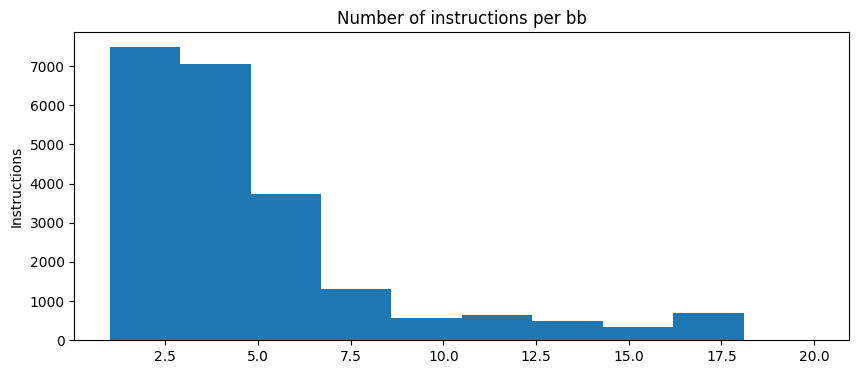

In [5]:
plt.figure(figsize=(10,4))
plt.hist(data_df.bb.map(len))
plt.title("Number of instructions per bb")
plt.ylabel("Instructions")
plt.show()

In [6]:
data_df["encoded_bb"] = data_df.bb.apply(lambda x: utils.encode_bb_from_vocab(x, vocab, max_insts=20))
data_df.head(10)

,bb,energy,encoded_bb
0,[movl $0x0],0.645165,[31]
1,"[callq, pushq %rbp, mov %rsp %rbp]",2.910575,"[7, 14, 499]"
2,"[popq %rbp, retq]",0.997157,"[9, 6]"
3,[movl $0x0],0.664772,[31]
4,"[cmpl $0x64, jnl 0x2c]",1.400952,"[407, 408]"
5,"[movl %eax, imull %eax, add $0x9 %eax, movsxdl...",2.334921,"[2, 397, 410, 29, 2]"
6,"[movl %eax, add $0x1 %eax, movl %eax, jmp]",2.419369,"[2, 30, 2, 4]"
7,"[cmpl $0x64, jnl 0x2c]",0.967748,"[407, 408]"
8,"[movl %eax, imull %eax, add $0x9 %eax, movsxdl...",1.612913,"[2, 397, 410, 29, 2]"
9,"[movl %eax, add $0x1 %eax, movl %eax, jmp]",2.419369,"[2, 30, 2, 4]"


# Optuna Trials

In [13]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "lstm-vocab-regression-study-good-dataset"
storage_name = f"sqlite:////Users/thodo/Documents/sxoli/diplomatiki/optuna-studies/lstm-vocab-regression-study.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="minimize")
study.set_user_attr("Loss", "RMSE")
study.set_user_attr("Special vocab tokens", "['unk': 0, 'pad': 1]")
study.set_user_attr("Max instructions", "20")

[I 2023-02-01 16:29:01,355] Using an existing study with name 'lstm-vocab-regression-study-good-dataset' instead of creating a new one.


Using an existing study with name 'lstm-vocab-regression-study-good-dataset' instead of creating a new one.


In [8]:
def objective(trial):

    embedding_size = trial.suggest_int("embedding_size", 64, 512)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 5)
    hidden_size = trial.suggest_int("hidden_size", 8, 128)
    dense_size = trial.suggest_int("dense_size", 16, 256)
    smaller_dense_size = trial.suggest_int("smaller_dense_size", 8, 64)
    batch_size_exp = trial.suggest_int("batch_size_exp", 3, 7)
    lstm_dropout = trial.suggest_float("lstm_dropout", 0, 0.2)
    dense_dropout = trial.suggest_float("dense_dropout", 0, 0.15)
    lr = trial.suggest_float("lr", 1e-4, 1e-2)
    lr_decay = trial.suggest_float("lr_decay", 0.05, 0.8)
    lr_decay_step = trial.suggest_int("lr_decay_step", 5, 20)

    batch_size = 2**batch_size_exp

    data_loaders = utils.get_vocab_data_dict(data_df=data_df, batch_size=batch_size)
    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    model = models.LSTM_Regressor(
        vocab_size=len(vocab),
        embedding_size=embedding_size,
        custom_embs=True,
        hidden_size=hidden_size,
        num_layers=lstm_layers,
        dense_size=dense_size,
        smaller_dense_size=smaller_dense_size,
        lstm_dropout=lstm_dropout,
        dense_dropout=dense_dropout,
    )
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=lr,
        epochs=200,
        batch_size=batch_size,
        early_stopping=True,
        lr_decay=lr_decay,
        lr_decay_step=lr_decay_step,
    )

    val_loss = train_results["val_loss"]

    return val_loss[-1]


study.optimize(objective, n_trials=100)

c:\Users\thodo\Documents\sxoli\diplomatiki\basic-block-energy-prediction\playground\energy-prediction\../../src\dataset.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(data_df.encoded_bb.tolist())
[I 2023-01-31 19:36:30,723] Trial 0 finished with value: 0.39499719832226526 and parameters: {'embedding_size': 322, 'lstm_layers': 3, 'hidden_size': 30, 'dense_size': 253, 'smaller_dense_size': 56, 'batch_size_exp': 4, 'lstm_dropout': 0.08902745167432534, 'dense_dropout': 0.053543771370505984, 'lr': 0.00955469601381345, 'lr_decay': 0.07979590078210776, 'lr_decay_step': 18}. Best is trial 0 with value: 0.39499719832226526.


Trial 0 finished with value: 0.39499719832226526 and parameters: {'embedding_size': 322, 'lstm_layers': 3, 'hidden_size': 30, 'dense_size': 253, 'smaller_dense_size': 56, 'batch_size_exp': 4, 'lstm_dropout': 0.08902745167432534, 'dense_dropout': 0.053543771370505984, 'lr': 0.00955469601381345, 'lr_decay': 0.07979590078210776, 'lr_decay_step': 18}. Best is trial 0 with value: 0.39499719832226526.


[I 2023-01-31 19:46:40,752] Trial 1 finished with value: 0.3268874251821135 and parameters: {'embedding_size': 424, 'lstm_layers': 2, 'hidden_size': 93, 'dense_size': 18, 'smaller_dense_size': 28, 'batch_size_exp': 3, 'lstm_dropout': 0.11616123240257198, 'dense_dropout': 0.0991891525673603, 'lr': 0.009422759237679303, 'lr_decay': 0.15404859352343242, 'lr_decay_step': 14}. Best is trial 1 with value: 0.3268874251821135.


Trial 1 finished with value: 0.3268874251821135 and parameters: {'embedding_size': 424, 'lstm_layers': 2, 'hidden_size': 93, 'dense_size': 18, 'smaller_dense_size': 28, 'batch_size_exp': 3, 'lstm_dropout': 0.11616123240257198, 'dense_dropout': 0.0991891525673603, 'lr': 0.009422759237679303, 'lr_decay': 0.15404859352343242, 'lr_decay_step': 14}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 19:47:31,443] Trial 2 finished with value: 0.525570397867876 and parameters: {'embedding_size': 207, 'lstm_layers': 5, 'hidden_size': 33, 'dense_size': 253, 'smaller_dense_size': 29, 'batch_size_exp': 7, 'lstm_dropout': 0.03734849394692861, 'dense_dropout': 0.08331869403429629, 'lr': 0.0010449678350462873, 'lr_decay': 0.29959653079082316, 'lr_decay_step': 11}. Best is trial 1 with value: 0.3268874251821135.


Trial 2 finished with value: 0.525570397867876 and parameters: {'embedding_size': 207, 'lstm_layers': 5, 'hidden_size': 33, 'dense_size': 253, 'smaller_dense_size': 29, 'batch_size_exp': 7, 'lstm_dropout': 0.03734849394692861, 'dense_dropout': 0.08331869403429629, 'lr': 0.0010449678350462873, 'lr_decay': 0.29959653079082316, 'lr_decay_step': 11}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 19:58:26,777] Trial 3 finished with value: 0.32967018350745186 and parameters: {'embedding_size': 272, 'lstm_layers': 2, 'hidden_size': 124, 'dense_size': 94, 'smaller_dense_size': 21, 'batch_size_exp': 3, 'lstm_dropout': 0.052406719142264094, 'dense_dropout': 0.05670681739322366, 'lr': 0.005527425013749287, 'lr_decay': 0.18195243221045782, 'lr_decay_step': 16}. Best is trial 1 with value: 0.3268874251821135.


Trial 3 finished with value: 0.32967018350745186 and parameters: {'embedding_size': 272, 'lstm_layers': 2, 'hidden_size': 124, 'dense_size': 94, 'smaller_dense_size': 21, 'batch_size_exp': 3, 'lstm_dropout': 0.052406719142264094, 'dense_dropout': 0.05670681739322366, 'lr': 0.005527425013749287, 'lr_decay': 0.18195243221045782, 'lr_decay_step': 16}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 20:01:05,816] Trial 4 finished with value: 0.4575497508049011 and parameters: {'embedding_size': 422, 'lstm_layers': 3, 'hidden_size': 84, 'dense_size': 65, 'smaller_dense_size': 50, 'batch_size_exp': 6, 'lstm_dropout': 0.11133778236073598, 'dense_dropout': 0.14240383018679323, 'lr': 0.004683925046632142, 'lr_decay': 0.508723127708345, 'lr_decay_step': 11}. Best is trial 1 with value: 0.3268874251821135.


Trial 4 finished with value: 0.4575497508049011 and parameters: {'embedding_size': 422, 'lstm_layers': 3, 'hidden_size': 84, 'dense_size': 65, 'smaller_dense_size': 50, 'batch_size_exp': 6, 'lstm_dropout': 0.11133778236073598, 'dense_dropout': 0.14240383018679323, 'lr': 0.004683925046632142, 'lr_decay': 0.508723127708345, 'lr_decay_step': 11}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 20:07:35,790] Trial 5 finished with value: 0.4122016539656988 and parameters: {'embedding_size': 318, 'lstm_layers': 1, 'hidden_size': 126, 'dense_size': 250, 'smaller_dense_size': 14, 'batch_size_exp': 3, 'lstm_dropout': 0.13838166027835072, 'dense_dropout': 0.04750955026258522, 'lr': 0.003836143509082426, 'lr_decay': 0.4109337777392313, 'lr_decay_step': 20}. Best is trial 1 with value: 0.3268874251821135.


Trial 5 finished with value: 0.4122016539656988 and parameters: {'embedding_size': 318, 'lstm_layers': 1, 'hidden_size': 126, 'dense_size': 250, 'smaller_dense_size': 14, 'batch_size_exp': 3, 'lstm_dropout': 0.13838166027835072, 'dense_dropout': 0.04750955026258522, 'lr': 0.003836143509082426, 'lr_decay': 0.4109337777392313, 'lr_decay_step': 20}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 20:11:49,112] Trial 6 finished with value: 0.5358689563429874 and parameters: {'embedding_size': 329, 'lstm_layers': 5, 'hidden_size': 97, 'dense_size': 154, 'smaller_dense_size': 30, 'batch_size_exp': 5, 'lstm_dropout': 0.07002579464311864, 'dense_dropout': 0.032774991941691235, 'lr': 0.0072437533921970755, 'lr_decay': 0.6756450826364209, 'lr_decay_step': 17}. Best is trial 1 with value: 0.3268874251821135.


Trial 6 finished with value: 0.5358689563429874 and parameters: {'embedding_size': 329, 'lstm_layers': 5, 'hidden_size': 97, 'dense_size': 154, 'smaller_dense_size': 30, 'batch_size_exp': 5, 'lstm_dropout': 0.07002579464311864, 'dense_dropout': 0.032774991941691235, 'lr': 0.0072437533921970755, 'lr_decay': 0.6756450826364209, 'lr_decay_step': 17}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 20:13:55,969] Trial 7 finished with value: 0.48643239719026227 and parameters: {'embedding_size': 394, 'lstm_layers': 2, 'hidden_size': 122, 'dense_size': 59, 'smaller_dense_size': 62, 'batch_size_exp': 6, 'lstm_dropout': 0.0835458434799562, 'dense_dropout': 0.032588654771898144, 'lr': 0.006811271829709411, 'lr_decay': 0.7770302417609053, 'lr_decay_step': 10}. Best is trial 1 with value: 0.3268874251821135.


Trial 7 finished with value: 0.48643239719026227 and parameters: {'embedding_size': 394, 'lstm_layers': 2, 'hidden_size': 122, 'dense_size': 59, 'smaller_dense_size': 62, 'batch_size_exp': 6, 'lstm_dropout': 0.0835458434799562, 'dense_dropout': 0.032588654771898144, 'lr': 0.006811271829709411, 'lr_decay': 0.7770302417609053, 'lr_decay_step': 10}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 20:14:56,047] Trial 8 finished with value: 0.4803072003757252 and parameters: {'embedding_size': 225, 'lstm_layers': 1, 'hidden_size': 12, 'dense_size': 197, 'smaller_dense_size': 40, 'batch_size_exp': 6, 'lstm_dropout': 0.052574932016880266, 'dense_dropout': 0.013679743200610371, 'lr': 0.0034517876713805896, 'lr_decay': 0.69317528479025, 'lr_decay_step': 11}. Best is trial 1 with value: 0.3268874251821135.


Trial 8 finished with value: 0.4803072003757252 and parameters: {'embedding_size': 225, 'lstm_layers': 1, 'hidden_size': 12, 'dense_size': 197, 'smaller_dense_size': 40, 'batch_size_exp': 6, 'lstm_dropout': 0.052574932016880266, 'dense_dropout': 0.013679743200610371, 'lr': 0.0034517876713805896, 'lr_decay': 0.69317528479025, 'lr_decay_step': 11}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 20:18:57,176] Trial 9 finished with value: 0.4810601262294728 and parameters: {'embedding_size': 153, 'lstm_layers': 3, 'hidden_size': 114, 'dense_size': 203, 'smaller_dense_size': 25, 'batch_size_exp': 5, 'lstm_dropout': 0.1034982589277441, 'dense_dropout': 0.003004386371753487, 'lr': 0.007261500762577656, 'lr_decay': 0.08860396277751904, 'lr_decay_step': 20}. Best is trial 1 with value: 0.3268874251821135.


Trial 9 finished with value: 0.4810601262294728 and parameters: {'embedding_size': 153, 'lstm_layers': 3, 'hidden_size': 114, 'dense_size': 203, 'smaller_dense_size': 25, 'batch_size_exp': 5, 'lstm_dropout': 0.1034982589277441, 'dense_dropout': 0.003004386371753487, 'lr': 0.007261500762577656, 'lr_decay': 0.08860396277751904, 'lr_decay_step': 20}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 20:24:32,437] Trial 10 finished with value: 0.471911365394112 and parameters: {'embedding_size': 506, 'lstm_layers': 4, 'hidden_size': 62, 'dense_size': 16, 'smaller_dense_size': 42, 'batch_size_exp': 4, 'lstm_dropout': 0.19926021333795815, 'dense_dropout': 0.10666802251230771, 'lr': 0.009369788028626265, 'lr_decay': 0.296648424022425, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


Trial 10 finished with value: 0.471911365394112 and parameters: {'embedding_size': 506, 'lstm_layers': 4, 'hidden_size': 62, 'dense_size': 16, 'smaller_dense_size': 42, 'batch_size_exp': 4, 'lstm_dropout': 0.19926021333795815, 'dense_dropout': 0.10666802251230771, 'lr': 0.009369788028626265, 'lr_decay': 0.296648424022425, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 20:31:26,660] Trial 11 finished with value: 0.39410857384937636 and parameters: {'embedding_size': 502, 'lstm_layers': 2, 'hidden_size': 93, 'dense_size': 90, 'smaller_dense_size': 12, 'batch_size_exp': 3, 'lstm_dropout': 0.0013724432253466035, 'dense_dropout': 0.08980773468673753, 'lr': 0.0015936097725188407, 'lr_decay': 0.20333020775070532, 'lr_decay_step': 15}. Best is trial 1 with value: 0.3268874251821135.


Trial 11 finished with value: 0.39410857384937636 and parameters: {'embedding_size': 502, 'lstm_layers': 2, 'hidden_size': 93, 'dense_size': 90, 'smaller_dense_size': 12, 'batch_size_exp': 3, 'lstm_dropout': 0.0013724432253466035, 'dense_dropout': 0.08980773468673753, 'lr': 0.0015936097725188407, 'lr_decay': 0.20333020775070532, 'lr_decay_step': 15}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 20:38:34,632] Trial 12 finished with value: 0.3822304188644373 and parameters: {'embedding_size': 101, 'lstm_layers': 2, 'hidden_size': 70, 'dense_size': 20, 'smaller_dense_size': 20, 'batch_size_exp': 3, 'lstm_dropout': 0.1450182346154409, 'dense_dropout': 0.1235817016002731, 'lr': 0.006122363110960482, 'lr_decay': 0.18595364293639718, 'lr_decay_step': 14}. Best is trial 1 with value: 0.3268874251821135.


Trial 12 finished with value: 0.3822304188644373 and parameters: {'embedding_size': 101, 'lstm_layers': 2, 'hidden_size': 70, 'dense_size': 20, 'smaller_dense_size': 20, 'batch_size_exp': 3, 'lstm_dropout': 0.1450182346154409, 'dense_dropout': 0.1235817016002731, 'lr': 0.006122363110960482, 'lr_decay': 0.18595364293639718, 'lr_decay_step': 14}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 20:42:55,836] Trial 13 finished with value: 0.41405782098178384 and parameters: {'embedding_size': 410, 'lstm_layers': 2, 'hidden_size': 104, 'dense_size': 115, 'smaller_dense_size': 21, 'batch_size_exp': 4, 'lstm_dropout': 0.02116593383430007, 'dense_dropout': 0.07091923915558712, 'lr': 0.00861710439618629, 'lr_decay': 0.22602249681954628, 'lr_decay_step': 15}. Best is trial 1 with value: 0.3268874251821135.


Trial 13 finished with value: 0.41405782098178384 and parameters: {'embedding_size': 410, 'lstm_layers': 2, 'hidden_size': 104, 'dense_size': 115, 'smaller_dense_size': 21, 'batch_size_exp': 4, 'lstm_dropout': 0.02116593383430007, 'dense_dropout': 0.07091923915558712, 'lr': 0.00861710439618629, 'lr_decay': 0.22602249681954628, 'lr_decay_step': 15}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 20:50:35,277] Trial 14 finished with value: 0.35874914599575874 and parameters: {'embedding_size': 245, 'lstm_layers': 1, 'hidden_size': 73, 'dense_size': 54, 'smaller_dense_size': 8, 'batch_size_exp': 3, 'lstm_dropout': 0.1398136606775875, 'dense_dropout': 0.10559307951736918, 'lr': 0.002429940869373155, 'lr_decay': 0.41348267341812805, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


Trial 14 finished with value: 0.35874914599575874 and parameters: {'embedding_size': 245, 'lstm_layers': 1, 'hidden_size': 73, 'dense_size': 54, 'smaller_dense_size': 8, 'batch_size_exp': 3, 'lstm_dropout': 0.1398136606775875, 'dense_dropout': 0.10559307951736918, 'lr': 0.002429940869373155, 'lr_decay': 0.41348267341812805, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 20:55:50,610] Trial 15 finished with value: 0.40483633439532285 and parameters: {'embedding_size': 369, 'lstm_layers': 4, 'hidden_size': 110, 'dense_size': 143, 'smaller_dense_size': 34, 'batch_size_exp': 4, 'lstm_dropout': 0.1818225400527321, 'dense_dropout': 0.06530329663842757, 'lr': 0.005535343278437285, 'lr_decay': 0.0771503766283393, 'lr_decay_step': 17}. Best is trial 1 with value: 0.3268874251821135.


Trial 15 finished with value: 0.40483633439532285 and parameters: {'embedding_size': 369, 'lstm_layers': 4, 'hidden_size': 110, 'dense_size': 143, 'smaller_dense_size': 34, 'batch_size_exp': 4, 'lstm_dropout': 0.1818225400527321, 'dense_dropout': 0.06530329663842757, 'lr': 0.005535343278437285, 'lr_decay': 0.0771503766283393, 'lr_decay_step': 17}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 21:05:49,184] Trial 16 finished with value: 0.37350591142598444 and parameters: {'embedding_size': 451, 'lstm_layers': 2, 'hidden_size': 84, 'dense_size': 100, 'smaller_dense_size': 19, 'batch_size_exp': 3, 'lstm_dropout': 0.053847134244370425, 'dense_dropout': 0.10750547740212318, 'lr': 0.008507183430089044, 'lr_decay': 0.49841501299653423, 'lr_decay_step': 13}. Best is trial 1 with value: 0.3268874251821135.


Trial 16 finished with value: 0.37350591142598444 and parameters: {'embedding_size': 451, 'lstm_layers': 2, 'hidden_size': 84, 'dense_size': 100, 'smaller_dense_size': 19, 'batch_size_exp': 3, 'lstm_dropout': 0.053847134244370425, 'dense_dropout': 0.10750547740212318, 'lr': 0.008507183430089044, 'lr_decay': 0.49841501299653423, 'lr_decay_step': 13}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 21:09:39,702] Trial 17 finished with value: 0.47477518772478583 and parameters: {'embedding_size': 266, 'lstm_layers': 4, 'hidden_size': 56, 'dense_size': 41, 'smaller_dense_size': 43, 'batch_size_exp': 4, 'lstm_dropout': 0.11233258938266899, 'dense_dropout': 0.14358839038249968, 'lr': 0.00036695973129755987, 'lr_decay': 0.31871278862979885, 'lr_decay_step': 16}. Best is trial 1 with value: 0.3268874251821135.


Trial 17 finished with value: 0.47477518772478583 and parameters: {'embedding_size': 266, 'lstm_layers': 4, 'hidden_size': 56, 'dense_size': 41, 'smaller_dense_size': 43, 'batch_size_exp': 4, 'lstm_dropout': 0.11233258938266899, 'dense_dropout': 0.14358839038249968, 'lr': 0.00036695973129755987, 'lr_decay': 0.31871278862979885, 'lr_decay_step': 16}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 21:13:31,544] Trial 18 finished with value: 0.48244904867116956 and parameters: {'embedding_size': 184, 'lstm_layers': 3, 'hidden_size': 128, 'dense_size': 86, 'smaller_dense_size': 34, 'batch_size_exp': 5, 'lstm_dropout': 0.07237139147988486, 'dense_dropout': 0.0909098653329749, 'lr': 0.00816347235808243, 'lr_decay': 0.14839236198575345, 'lr_decay_step': 13}. Best is trial 1 with value: 0.3268874251821135.


Trial 18 finished with value: 0.48244904867116956 and parameters: {'embedding_size': 184, 'lstm_layers': 3, 'hidden_size': 128, 'dense_size': 86, 'smaller_dense_size': 34, 'batch_size_exp': 5, 'lstm_dropout': 0.07237139147988486, 'dense_dropout': 0.0909098653329749, 'lr': 0.00816347235808243, 'lr_decay': 0.14839236198575345, 'lr_decay_step': 13}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 21:20:05,344] Trial 19 finished with value: 0.40447366519373806 and parameters: {'embedding_size': 288, 'lstm_layers': 1, 'hidden_size': 112, 'dense_size': 163, 'smaller_dense_size': 26, 'batch_size_exp': 3, 'lstm_dropout': 0.16666307734993463, 'dense_dropout': 0.12112217218474396, 'lr': 0.004650765149079432, 'lr_decay': 0.24805569703594132, 'lr_decay_step': 18}. Best is trial 1 with value: 0.3268874251821135.


Trial 19 finished with value: 0.40447366519373806 and parameters: {'embedding_size': 288, 'lstm_layers': 1, 'hidden_size': 112, 'dense_size': 163, 'smaller_dense_size': 26, 'batch_size_exp': 3, 'lstm_dropout': 0.16666307734993463, 'dense_dropout': 0.12112217218474396, 'lr': 0.004650765149079432, 'lr_decay': 0.24805569703594132, 'lr_decay_step': 18}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 21:20:40,357] Trial 20 finished with value: 0.5123500683728386 and parameters: {'embedding_size': 359, 'lstm_layers': 2, 'hidden_size': 49, 'dense_size': 121, 'smaller_dense_size': 15, 'batch_size_exp': 7, 'lstm_dropout': 0.12304350618552963, 'dense_dropout': 0.0556988816726094, 'lr': 0.006062895928367853, 'lr_decay': 0.1410710210818703, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


Trial 20 finished with value: 0.5123500683728386 and parameters: {'embedding_size': 359, 'lstm_layers': 2, 'hidden_size': 49, 'dense_size': 121, 'smaller_dense_size': 15, 'batch_size_exp': 7, 'lstm_dropout': 0.12304350618552963, 'dense_dropout': 0.0556988816726094, 'lr': 0.006062895928367853, 'lr_decay': 0.1410710210818703, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 21:29:21,280] Trial 21 finished with value: 0.34232320652533604 and parameters: {'embedding_size': 258, 'lstm_layers': 1, 'hidden_size': 76, 'dense_size': 49, 'smaller_dense_size': 9, 'batch_size_exp': 3, 'lstm_dropout': 0.1454880706244602, 'dense_dropout': 0.10295914839253748, 'lr': 0.0023506413157271303, 'lr_decay': 0.3975935628125141, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


Trial 21 finished with value: 0.34232320652533604 and parameters: {'embedding_size': 258, 'lstm_layers': 1, 'hidden_size': 76, 'dense_size': 49, 'smaller_dense_size': 9, 'batch_size_exp': 3, 'lstm_dropout': 0.1454880706244602, 'dense_dropout': 0.10295914839253748, 'lr': 0.0023506413157271303, 'lr_decay': 0.3975935628125141, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 21:39:18,093] Trial 22 finished with value: 0.33697432991264115 and parameters: {'embedding_size': 285, 'lstm_layers': 1, 'hidden_size': 86, 'dense_size': 35, 'smaller_dense_size': 8, 'batch_size_exp': 3, 'lstm_dropout': 0.16380110782082913, 'dense_dropout': 0.07942045561813837, 'lr': 0.0024249535908487233, 'lr_decay': 0.5051475735839165, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


Trial 22 finished with value: 0.33697432991264115 and parameters: {'embedding_size': 285, 'lstm_layers': 1, 'hidden_size': 86, 'dense_size': 35, 'smaller_dense_size': 8, 'batch_size_exp': 3, 'lstm_dropout': 0.16380110782082913, 'dense_dropout': 0.07942045561813837, 'lr': 0.0024249535908487233, 'lr_decay': 0.5051475735839165, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 21:44:09,396] Trial 23 finished with value: 0.44118293760706195 and parameters: {'embedding_size': 153, 'lstm_layers': 2, 'hidden_size': 96, 'dense_size': 34, 'smaller_dense_size': 16, 'batch_size_exp': 4, 'lstm_dropout': 0.17768928147387086, 'dense_dropout': 0.07655585968137961, 'lr': 0.0032099369959582716, 'lr_decay': 0.5197151424841652, 'lr_decay_step': 9}. Best is trial 1 with value: 0.3268874251821135.


Trial 23 finished with value: 0.44118293760706195 and parameters: {'embedding_size': 153, 'lstm_layers': 2, 'hidden_size': 96, 'dense_size': 34, 'smaller_dense_size': 16, 'batch_size_exp': 4, 'lstm_dropout': 0.17768928147387086, 'dense_dropout': 0.07655585968137961, 'lr': 0.0032099369959582716, 'lr_decay': 0.5197151424841652, 'lr_decay_step': 9}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 21:52:29,060] Trial 24 finished with value: 0.34924643323840204 and parameters: {'embedding_size': 294, 'lstm_layers': 1, 'hidden_size': 83, 'dense_size': 81, 'smaller_dense_size': 23, 'batch_size_exp': 3, 'lstm_dropout': 0.15434737890779165, 'dense_dropout': 0.04080300018301772, 'lr': 0.00012056952236738118, 'lr_decay': 0.5923281896435183, 'lr_decay_step': 14}. Best is trial 1 with value: 0.3268874251821135.


Trial 24 finished with value: 0.34924643323840204 and parameters: {'embedding_size': 294, 'lstm_layers': 1, 'hidden_size': 83, 'dense_size': 81, 'smaller_dense_size': 23, 'batch_size_exp': 3, 'lstm_dropout': 0.15434737890779165, 'dense_dropout': 0.04080300018301772, 'lr': 0.00012056952236738118, 'lr_decay': 0.5923281896435183, 'lr_decay_step': 14}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 21:57:07,738] Trial 25 finished with value: 0.41307053111976 and parameters: {'embedding_size': 353, 'lstm_layers': 2, 'hidden_size': 99, 'dense_size': 69, 'smaller_dense_size': 28, 'batch_size_exp': 4, 'lstm_dropout': 0.1228938343040304, 'dense_dropout': 0.06412449966535336, 'lr': 0.003973478533421904, 'lr_decay': 0.33384411070817077, 'lr_decay_step': 12}. Best is trial 1 with value: 0.3268874251821135.


Trial 25 finished with value: 0.41307053111976 and parameters: {'embedding_size': 353, 'lstm_layers': 2, 'hidden_size': 99, 'dense_size': 69, 'smaller_dense_size': 28, 'batch_size_exp': 4, 'lstm_dropout': 0.1228938343040304, 'dense_dropout': 0.06412449966535336, 'lr': 0.003973478533421904, 'lr_decay': 0.33384411070817077, 'lr_decay_step': 12}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 22:02:41,636] Trial 26 finished with value: 0.3781851890854083 and parameters: {'embedding_size': 448, 'lstm_layers': 1, 'hidden_size': 87, 'dense_size': 34, 'smaller_dense_size': 19, 'batch_size_exp': 3, 'lstm_dropout': 0.09378549162772325, 'dense_dropout': 0.09289450068435745, 'lr': 0.0027019316183579467, 'lr_decay': 0.5760235536442496, 'lr_decay_step': 15}. Best is trial 1 with value: 0.3268874251821135.


Trial 26 finished with value: 0.3781851890854083 and parameters: {'embedding_size': 448, 'lstm_layers': 1, 'hidden_size': 87, 'dense_size': 34, 'smaller_dense_size': 19, 'batch_size_exp': 3, 'lstm_dropout': 0.09378549162772325, 'dense_dropout': 0.09289450068435745, 'lr': 0.0027019316183579467, 'lr_decay': 0.5760235536442496, 'lr_decay_step': 15}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 22:06:53,989] Trial 27 finished with value: 0.45691314564763214 and parameters: {'embedding_size': 289, 'lstm_layers': 2, 'hidden_size': 117, 'dense_size': 18, 'smaller_dense_size': 37, 'batch_size_exp': 4, 'lstm_dropout': 0.19663279973603948, 'dense_dropout': 0.12101376175360087, 'lr': 0.001448709131398134, 'lr_decay': 0.3570179092839464, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


Trial 27 finished with value: 0.45691314564763214 and parameters: {'embedding_size': 289, 'lstm_layers': 2, 'hidden_size': 117, 'dense_size': 18, 'smaller_dense_size': 37, 'batch_size_exp': 4, 'lstm_dropout': 0.19663279973603948, 'dense_dropout': 0.12101376175360087, 'lr': 0.001448709131398134, 'lr_decay': 0.3570179092839464, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 22:12:09,449] Trial 28 finished with value: 0.41527273803014697 and parameters: {'embedding_size': 180, 'lstm_layers': 1, 'hidden_size': 106, 'dense_size': 112, 'smaller_dense_size': 11, 'batch_size_exp': 3, 'lstm_dropout': 0.16227991761891997, 'dense_dropout': 0.07778460918257046, 'lr': 0.005225861065694375, 'lr_decay': 0.4708452822423181, 'lr_decay_step': 12}. Best is trial 1 with value: 0.3268874251821135.


Trial 28 finished with value: 0.41527273803014697 and parameters: {'embedding_size': 180, 'lstm_layers': 1, 'hidden_size': 106, 'dense_size': 112, 'smaller_dense_size': 11, 'batch_size_exp': 3, 'lstm_dropout': 0.16227991761891997, 'dense_dropout': 0.07778460918257046, 'lr': 0.005225861065694375, 'lr_decay': 0.4708452822423181, 'lr_decay_step': 12}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 22:15:35,699] Trial 29 finished with value: 0.4947967611361241 and parameters: {'embedding_size': 316, 'lstm_layers': 3, 'hidden_size': 43, 'dense_size': 39, 'smaller_dense_size': 49, 'batch_size_exp': 5, 'lstm_dropout': 0.08388462426459296, 'dense_dropout': 0.05632651761405519, 'lr': 0.009547177720173529, 'lr_decay': 0.05791647636001607, 'lr_decay_step': 19}. Best is trial 1 with value: 0.3268874251821135.


Trial 29 finished with value: 0.4947967611361241 and parameters: {'embedding_size': 316, 'lstm_layers': 3, 'hidden_size': 43, 'dense_size': 39, 'smaller_dense_size': 49, 'batch_size_exp': 5, 'lstm_dropout': 0.08388462426459296, 'dense_dropout': 0.05632651761405519, 'lr': 0.009547177720173529, 'lr_decay': 0.05791647636001607, 'lr_decay_step': 19}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 22:21:11,387] Trial 30 finished with value: 0.4604326751913956 and parameters: {'embedding_size': 462, 'lstm_layers': 3, 'hidden_size': 76, 'dense_size': 74, 'smaller_dense_size': 32, 'batch_size_exp': 4, 'lstm_dropout': 0.12640982888577557, 'dense_dropout': 0.02899750983880963, 'lr': 0.00990060516831306, 'lr_decay': 0.2610660061187493, 'lr_decay_step': 17}. Best is trial 1 with value: 0.3268874251821135.


Trial 30 finished with value: 0.4604326751913956 and parameters: {'embedding_size': 462, 'lstm_layers': 3, 'hidden_size': 76, 'dense_size': 74, 'smaller_dense_size': 32, 'batch_size_exp': 4, 'lstm_dropout': 0.12640982888577557, 'dense_dropout': 0.02899750983880963, 'lr': 0.00990060516831306, 'lr_decay': 0.2610660061187493, 'lr_decay_step': 17}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 22:28:09,679] Trial 31 finished with value: 0.3712995595509006 and parameters: {'embedding_size': 256, 'lstm_layers': 1, 'hidden_size': 63, 'dense_size': 50, 'smaller_dense_size': 8, 'batch_size_exp': 3, 'lstm_dropout': 0.1505399822818269, 'dense_dropout': 0.09901980923619016, 'lr': 0.0021168251601141764, 'lr_decay': 0.1352950193608062, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


Trial 31 finished with value: 0.3712995595509006 and parameters: {'embedding_size': 256, 'lstm_layers': 1, 'hidden_size': 63, 'dense_size': 50, 'smaller_dense_size': 8, 'batch_size_exp': 3, 'lstm_dropout': 0.1505399822818269, 'dense_dropout': 0.09901980923619016, 'lr': 0.0021168251601141764, 'lr_decay': 0.1352950193608062, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 22:37:48,576] Trial 32 finished with value: 0.3708726223891995 and parameters: {'embedding_size': 213, 'lstm_layers': 1, 'hidden_size': 78, 'dense_size': 48, 'smaller_dense_size': 11, 'batch_size_exp': 3, 'lstm_dropout': 0.17257683297328033, 'dense_dropout': 0.0839716877166968, 'lr': 0.0007438174365475112, 'lr_decay': 0.4410059937811171, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


Trial 32 finished with value: 0.3708726223891995 and parameters: {'embedding_size': 213, 'lstm_layers': 1, 'hidden_size': 78, 'dense_size': 48, 'smaller_dense_size': 11, 'batch_size_exp': 3, 'lstm_dropout': 0.17257683297328033, 'dense_dropout': 0.0839716877166968, 'lr': 0.0007438174365475112, 'lr_decay': 0.4410059937811171, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 22:44:40,424] Trial 33 finished with value: 0.387750081717968 and parameters: {'embedding_size': 235, 'lstm_layers': 1, 'hidden_size': 92, 'dense_size': 29, 'smaller_dense_size': 16, 'batch_size_exp': 3, 'lstm_dropout': 0.0299712557099049, 'dense_dropout': 0.13442681504298012, 'lr': 0.0017321843369115615, 'lr_decay': 0.6128352051595134, 'lr_decay_step': 10}. Best is trial 1 with value: 0.3268874251821135.


Trial 33 finished with value: 0.387750081717968 and parameters: {'embedding_size': 235, 'lstm_layers': 1, 'hidden_size': 92, 'dense_size': 29, 'smaller_dense_size': 16, 'batch_size_exp': 3, 'lstm_dropout': 0.0299712557099049, 'dense_dropout': 0.13442681504298012, 'lr': 0.0017321843369115615, 'lr_decay': 0.6128352051595134, 'lr_decay_step': 10}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 22:52:51,492] Trial 34 finished with value: 0.348050544899638 and parameters: {'embedding_size': 272, 'lstm_layers': 2, 'hidden_size': 66, 'dense_size': 56, 'smaller_dense_size': 24, 'batch_size_exp': 3, 'lstm_dropout': 0.13097116848181678, 'dense_dropout': 0.11336485964655398, 'lr': 0.003011791959024568, 'lr_decay': 0.37196934212427013, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


Trial 34 finished with value: 0.348050544899638 and parameters: {'embedding_size': 272, 'lstm_layers': 2, 'hidden_size': 66, 'dense_size': 56, 'smaller_dense_size': 24, 'batch_size_exp': 3, 'lstm_dropout': 0.13097116848181678, 'dense_dropout': 0.11336485964655398, 'lr': 0.003011791959024568, 'lr_decay': 0.37196934212427013, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 23:03:13,481] Trial 35 finished with value: 0.4587044789315128 and parameters: {'embedding_size': 323, 'lstm_layers': 1, 'hidden_size': 56, 'dense_size': 99, 'smaller_dense_size': 13, 'batch_size_exp': 4, 'lstm_dropout': 0.10662420248140361, 'dense_dropout': 0.08307271234498426, 'lr': 0.004259242259255134, 'lr_decay': 0.5400243441865976, 'lr_decay_step': 9}. Best is trial 1 with value: 0.3268874251821135.


Trial 35 finished with value: 0.4587044789315128 and parameters: {'embedding_size': 323, 'lstm_layers': 1, 'hidden_size': 56, 'dense_size': 99, 'smaller_dense_size': 13, 'batch_size_exp': 4, 'lstm_dropout': 0.10662420248140361, 'dense_dropout': 0.08307271234498426, 'lr': 0.004259242259255134, 'lr_decay': 0.5400243441865976, 'lr_decay_step': 9}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 23:14:49,757] Trial 36 finished with value: 0.35689245032206657 and parameters: {'embedding_size': 194, 'lstm_layers': 2, 'hidden_size': 104, 'dense_size': 69, 'smaller_dense_size': 29, 'batch_size_exp': 3, 'lstm_dropout': 0.1876972885394385, 'dense_dropout': 0.06544353703854391, 'lr': 0.0010716322478000668, 'lr_decay': 0.2861565642395316, 'lr_decay_step': 11}. Best is trial 1 with value: 0.3268874251821135.


Trial 36 finished with value: 0.35689245032206657 and parameters: {'embedding_size': 194, 'lstm_layers': 2, 'hidden_size': 104, 'dense_size': 69, 'smaller_dense_size': 29, 'batch_size_exp': 3, 'lstm_dropout': 0.1876972885394385, 'dense_dropout': 0.06544353703854391, 'lr': 0.0010716322478000668, 'lr_decay': 0.2861565642395316, 'lr_decay_step': 11}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 23:15:25,464] Trial 37 finished with value: 0.47748463381739226 and parameters: {'embedding_size': 383, 'lstm_layers': 1, 'hidden_size': 30, 'dense_size': 26, 'smaller_dense_size': 17, 'batch_size_exp': 6, 'lstm_dropout': 0.11552997717776485, 'dense_dropout': 0.04635499605424351, 'lr': 0.007514948897301272, 'lr_decay': 0.6471749981859554, 'lr_decay_step': 16}. Best is trial 1 with value: 0.3268874251821135.


Trial 37 finished with value: 0.47748463381739226 and parameters: {'embedding_size': 383, 'lstm_layers': 1, 'hidden_size': 30, 'dense_size': 26, 'smaller_dense_size': 17, 'batch_size_exp': 6, 'lstm_dropout': 0.11552997717776485, 'dense_dropout': 0.04635499605424351, 'lr': 0.007514948897301272, 'lr_decay': 0.6471749981859554, 'lr_decay_step': 16}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 23:22:22,997] Trial 38 finished with value: 0.3830649226596813 and parameters: {'embedding_size': 331, 'lstm_layers': 3, 'hidden_size': 80, 'dense_size': 131, 'smaller_dense_size': 9, 'batch_size_exp': 3, 'lstm_dropout': 0.15876826884124778, 'dense_dropout': 0.09732732796023957, 'lr': 0.0036588403129020346, 'lr_decay': 0.11101552377940341, 'lr_decay_step': 10}. Best is trial 1 with value: 0.3268874251821135.


Trial 38 finished with value: 0.3830649226596813 and parameters: {'embedding_size': 331, 'lstm_layers': 3, 'hidden_size': 80, 'dense_size': 131, 'smaller_dense_size': 9, 'batch_size_exp': 3, 'lstm_dropout': 0.15876826884124778, 'dense_dropout': 0.09732732796023957, 'lr': 0.0036588403129020346, 'lr_decay': 0.11101552377940341, 'lr_decay_step': 10}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 23:26:44,887] Trial 39 finished with value: 0.7329408874829039 and parameters: {'embedding_size': 68, 'lstm_layers': 5, 'hidden_size': 120, 'dense_size': 60, 'smaller_dense_size': 22, 'batch_size_exp': 4, 'lstm_dropout': 0.1359382958008602, 'dense_dropout': 0.08357502006725986, 'lr': 0.006595050422418253, 'lr_decay': 0.7457731743792507, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


Trial 39 finished with value: 0.7329408874829039 and parameters: {'embedding_size': 68, 'lstm_layers': 5, 'hidden_size': 120, 'dense_size': 60, 'smaller_dense_size': 22, 'batch_size_exp': 4, 'lstm_dropout': 0.1359382958008602, 'dense_dropout': 0.08357502006725986, 'lr': 0.006595050422418253, 'lr_decay': 0.7457731743792507, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 23:41:13,453] Trial 40 finished with value: 0.3417018582530346 and parameters: {'embedding_size': 301, 'lstm_layers': 2, 'hidden_size': 13, 'dense_size': 180, 'smaller_dense_size': 59, 'batch_size_exp': 3, 'lstm_dropout': 0.06635175916044697, 'dense_dropout': 0.021393749828999213, 'lr': 0.002183404597665661, 'lr_decay': 0.3866577775316991, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


Trial 40 finished with value: 0.3417018582530346 and parameters: {'embedding_size': 301, 'lstm_layers': 2, 'hidden_size': 13, 'dense_size': 180, 'smaller_dense_size': 59, 'batch_size_exp': 3, 'lstm_dropout': 0.06635175916044697, 'dense_dropout': 0.021393749828999213, 'lr': 0.002183404597665661, 'lr_decay': 0.3866577775316991, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-01-31 23:48:50,739] Trial 41 finished with value: 0.37539968607566687 and parameters: {'embedding_size': 305, 'lstm_layers': 2, 'hidden_size': 9, 'dense_size': 173, 'smaller_dense_size': 63, 'batch_size_exp': 3, 'lstm_dropout': 0.05382700901027353, 'dense_dropout': 0.0002650401857642176, 'lr': 0.002353453737560963, 'lr_decay': 0.36898764838714526, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


Trial 41 finished with value: 0.37539968607566687 and parameters: {'embedding_size': 305, 'lstm_layers': 2, 'hidden_size': 9, 'dense_size': 173, 'smaller_dense_size': 63, 'batch_size_exp': 3, 'lstm_dropout': 0.05382700901027353, 'dense_dropout': 0.0002650401857642176, 'lr': 0.002353453737560963, 'lr_decay': 0.36898764838714526, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 00:00:21,708] Trial 42 finished with value: 0.43011493875401424 and parameters: {'embedding_size': 348, 'lstm_layers': 2, 'hidden_size': 21, 'dense_size': 223, 'smaller_dense_size': 55, 'batch_size_exp': 3, 'lstm_dropout': 0.07023262904876251, 'dense_dropout': 0.01849887135887647, 'lr': 0.0029400332268986057, 'lr_decay': 0.45179849814799855, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


Trial 42 finished with value: 0.43011493875401424 and parameters: {'embedding_size': 348, 'lstm_layers': 2, 'hidden_size': 21, 'dense_size': 223, 'smaller_dense_size': 55, 'batch_size_exp': 3, 'lstm_dropout': 0.07023262904876251, 'dense_dropout': 0.01849887135887647, 'lr': 0.0029400332268986057, 'lr_decay': 0.45179849814799855, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 00:05:37,743] Trial 43 finished with value: 0.41736676061933187 and parameters: {'embedding_size': 228, 'lstm_layers': 1, 'hidden_size': 41, 'dense_size': 175, 'smaller_dense_size': 56, 'batch_size_exp': 3, 'lstm_dropout': 0.04082887892855282, 'dense_dropout': 0.03820623435699766, 'lr': 0.0019414295778232568, 'lr_decay': 0.18922457014068497, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


Trial 43 finished with value: 0.41736676061933187 and parameters: {'embedding_size': 228, 'lstm_layers': 1, 'hidden_size': 41, 'dense_size': 175, 'smaller_dense_size': 56, 'batch_size_exp': 3, 'lstm_dropout': 0.04082887892855282, 'dense_dropout': 0.03820623435699766, 'lr': 0.0019414295778232568, 'lr_decay': 0.18922457014068497, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 00:06:06,909] Trial 44 finished with value: 0.4731794455472161 and parameters: {'embedding_size': 271, 'lstm_layers': 3, 'hidden_size': 87, 'dense_size': 43, 'smaller_dense_size': 45, 'batch_size_exp': 7, 'lstm_dropout': 0.10096938681257561, 'dense_dropout': 0.017883930873090342, 'lr': 0.004378685467512179, 'lr_decay': 0.4035257956937046, 'lr_decay_step': 9}. Best is trial 1 with value: 0.3268874251821135.


Trial 44 finished with value: 0.4731794455472161 and parameters: {'embedding_size': 271, 'lstm_layers': 3, 'hidden_size': 87, 'dense_size': 43, 'smaller_dense_size': 45, 'batch_size_exp': 7, 'lstm_dropout': 0.10096938681257561, 'dense_dropout': 0.017883930873090342, 'lr': 0.004378685467512179, 'lr_decay': 0.4035257956937046, 'lr_decay_step': 9}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 00:12:05,728] Trial 45 finished with value: 0.3674042425168458 and parameters: {'embedding_size': 419, 'lstm_layers': 2, 'hidden_size': 16, 'dense_size': 201, 'smaller_dense_size': 39, 'batch_size_exp': 3, 'lstm_dropout': 0.061388334726655766, 'dense_dropout': 0.008776690387332281, 'lr': 0.0012491373464908256, 'lr_decay': 0.3981738451471832, 'lr_decay_step': 14}. Best is trial 1 with value: 0.3268874251821135.


Trial 45 finished with value: 0.3674042425168458 and parameters: {'embedding_size': 419, 'lstm_layers': 2, 'hidden_size': 16, 'dense_size': 201, 'smaller_dense_size': 39, 'batch_size_exp': 3, 'lstm_dropout': 0.061388334726655766, 'dense_dropout': 0.008776690387332281, 'lr': 0.0012491373464908256, 'lr_decay': 0.3981738451471832, 'lr_decay_step': 14}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 00:16:58,276] Trial 46 finished with value: 0.4846528383146087 and parameters: {'embedding_size': 154, 'lstm_layers': 2, 'hidden_size': 72, 'dense_size': 227, 'smaller_dense_size': 59, 'batch_size_exp': 4, 'lstm_dropout': 0.010391783323601828, 'dense_dropout': 0.11423492707404966, 'lr': 0.0034582170750679466, 'lr_decay': 0.4816960884145059, 'lr_decay_step': 16}. Best is trial 1 with value: 0.3268874251821135.


Trial 46 finished with value: 0.4846528383146087 and parameters: {'embedding_size': 154, 'lstm_layers': 2, 'hidden_size': 72, 'dense_size': 227, 'smaller_dense_size': 59, 'batch_size_exp': 4, 'lstm_dropout': 0.010391783323601828, 'dense_dropout': 0.11423492707404966, 'lr': 0.0034582170750679466, 'lr_decay': 0.4816960884145059, 'lr_decay_step': 16}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 00:28:17,126] Trial 47 finished with value: 0.3591008264317735 and parameters: {'embedding_size': 486, 'lstm_layers': 1, 'hidden_size': 90, 'dense_size': 149, 'smaller_dense_size': 31, 'batch_size_exp': 3, 'lstm_dropout': 0.14660911443051722, 'dense_dropout': 0.02437977728096863, 'lr': 0.00896876972352758, 'lr_decay': 0.5517735969519652, 'lr_decay_step': 11}. Best is trial 1 with value: 0.3268874251821135.


Trial 47 finished with value: 0.3591008264317735 and parameters: {'embedding_size': 486, 'lstm_layers': 1, 'hidden_size': 90, 'dense_size': 149, 'smaller_dense_size': 31, 'batch_size_exp': 3, 'lstm_dropout': 0.14660911443051722, 'dense_dropout': 0.02437977728096863, 'lr': 0.00896876972352758, 'lr_decay': 0.5517735969519652, 'lr_decay_step': 11}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 00:31:10,591] Trial 48 finished with value: 0.42909557913704743 and parameters: {'embedding_size': 254, 'lstm_layers': 2, 'hidden_size': 99, 'dense_size': 16, 'smaller_dense_size': 27, 'batch_size_exp': 4, 'lstm_dropout': 0.04415598405721488, 'dense_dropout': 0.07243418448113535, 'lr': 0.0024608141650728143, 'lr_decay': 0.17474598910574426, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


Trial 48 finished with value: 0.42909557913704743 and parameters: {'embedding_size': 254, 'lstm_layers': 2, 'hidden_size': 99, 'dense_size': 16, 'smaller_dense_size': 27, 'batch_size_exp': 4, 'lstm_dropout': 0.04415598405721488, 'dense_dropout': 0.07243418448113535, 'lr': 0.0024608141650728143, 'lr_decay': 0.17474598910574426, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 00:32:18,484] Trial 49 finished with value: 0.4524310993797639 and parameters: {'embedding_size': 396, 'lstm_layers': 3, 'hidden_size': 24, 'dense_size': 188, 'smaller_dense_size': 53, 'batch_size_exp': 6, 'lstm_dropout': 0.09044659059860562, 'dense_dropout': 0.10227440737696022, 'lr': 0.005156926596258638, 'lr_decay': 0.21635091936821613, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


Trial 49 finished with value: 0.4524310993797639 and parameters: {'embedding_size': 396, 'lstm_layers': 3, 'hidden_size': 24, 'dense_size': 188, 'smaller_dense_size': 53, 'batch_size_exp': 6, 'lstm_dropout': 0.09044659059860562, 'dense_dropout': 0.10227440737696022, 'lr': 0.005156926596258638, 'lr_decay': 0.21635091936821613, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 00:40:16,866] Trial 50 finished with value: 0.3579731113060401 and parameters: {'embedding_size': 214, 'lstm_layers': 1, 'hidden_size': 124, 'dense_size': 96, 'smaller_dense_size': 18, 'batch_size_exp': 3, 'lstm_dropout': 0.07824073332177842, 'dense_dropout': 0.1291356911989842, 'lr': 0.0006909199988662986, 'lr_decay': 0.276496559788387, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


Trial 50 finished with value: 0.3579731113060401 and parameters: {'embedding_size': 214, 'lstm_layers': 1, 'hidden_size': 124, 'dense_size': 96, 'smaller_dense_size': 18, 'batch_size_exp': 3, 'lstm_dropout': 0.07824073332177842, 'dense_dropout': 0.1291356911989842, 'lr': 0.0006909199988662986, 'lr_decay': 0.276496559788387, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 00:46:53,657] Trial 51 finished with value: 0.3729552492285715 and parameters: {'embedding_size': 281, 'lstm_layers': 2, 'hidden_size': 37, 'dense_size': 59, 'smaller_dense_size': 25, 'batch_size_exp': 3, 'lstm_dropout': 0.1311507813673065, 'dense_dropout': 0.11495298452070146, 'lr': 0.0030110738312083504, 'lr_decay': 0.3699515727088779, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


Trial 51 finished with value: 0.3729552492285715 and parameters: {'embedding_size': 281, 'lstm_layers': 2, 'hidden_size': 37, 'dense_size': 59, 'smaller_dense_size': 25, 'batch_size_exp': 3, 'lstm_dropout': 0.1311507813673065, 'dense_dropout': 0.11495298452070146, 'lr': 0.0030110738312083504, 'lr_decay': 0.3699515727088779, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 00:53:41,634] Trial 52 finished with value: 0.35514134282787 and parameters: {'embedding_size': 268, 'lstm_layers': 2, 'hidden_size': 57, 'dense_size': 78, 'smaller_dense_size': 23, 'batch_size_exp': 3, 'lstm_dropout': 0.14165570888941473, 'dense_dropout': 0.11401741200099577, 'lr': 0.002131998457960667, 'lr_decay': 0.3379729883120345, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


Trial 52 finished with value: 0.35514134282787 and parameters: {'embedding_size': 268, 'lstm_layers': 2, 'hidden_size': 57, 'dense_size': 78, 'smaller_dense_size': 23, 'batch_size_exp': 3, 'lstm_dropout': 0.14165570888941473, 'dense_dropout': 0.11401741200099577, 'lr': 0.002131998457960667, 'lr_decay': 0.3379729883120345, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 01:03:20,412] Trial 53 finished with value: 0.40217375559698937 and parameters: {'embedding_size': 245, 'lstm_layers': 2, 'hidden_size': 66, 'dense_size': 53, 'smaller_dense_size': 14, 'batch_size_exp': 3, 'lstm_dropout': 0.11893808135246858, 'dense_dropout': 0.09034255975709898, 'lr': 0.005785810262068783, 'lr_decay': 0.4298725966119342, 'lr_decay_step': 9}. Best is trial 1 with value: 0.3268874251821135.


Trial 53 finished with value: 0.40217375559698937 and parameters: {'embedding_size': 245, 'lstm_layers': 2, 'hidden_size': 66, 'dense_size': 53, 'smaller_dense_size': 14, 'batch_size_exp': 3, 'lstm_dropout': 0.11893808135246858, 'dense_dropout': 0.09034255975709898, 'lr': 0.005785810262068783, 'lr_decay': 0.4298725966119342, 'lr_decay_step': 9}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 01:07:08,941] Trial 54 finished with value: 0.40923696497212286 and parameters: {'embedding_size': 303, 'lstm_layers': 2, 'hidden_size': 67, 'dense_size': 33, 'smaller_dense_size': 10, 'batch_size_exp': 5, 'lstm_dropout': 0.13560787563975638, 'dense_dropout': 0.10694233687376478, 'lr': 0.0016453595273599963, 'lr_decay': 0.30131837594960276, 'lr_decay_step': 13}. Best is trial 1 with value: 0.3268874251821135.


Trial 54 finished with value: 0.40923696497212286 and parameters: {'embedding_size': 303, 'lstm_layers': 2, 'hidden_size': 67, 'dense_size': 33, 'smaller_dense_size': 10, 'batch_size_exp': 5, 'lstm_dropout': 0.13560787563975638, 'dense_dropout': 0.10694233687376478, 'lr': 0.0016453595273599963, 'lr_decay': 0.30131837594960276, 'lr_decay_step': 13}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 01:24:29,984] Trial 55 finished with value: 0.421498544594293 and parameters: {'embedding_size': 335, 'lstm_layers': 4, 'hidden_size': 75, 'dense_size': 24, 'smaller_dense_size': 25, 'batch_size_exp': 3, 'lstm_dropout': 0.16818697429550744, 'dense_dropout': 0.13553933788939987, 'lr': 0.003976998668059459, 'lr_decay': 0.5069813808341804, 'lr_decay_step': 18}. Best is trial 1 with value: 0.3268874251821135.


Trial 55 finished with value: 0.421498544594293 and parameters: {'embedding_size': 335, 'lstm_layers': 4, 'hidden_size': 75, 'dense_size': 24, 'smaller_dense_size': 25, 'batch_size_exp': 3, 'lstm_dropout': 0.16818697429550744, 'dense_dropout': 0.13553933788939987, 'lr': 0.003976998668059459, 'lr_decay': 0.5069813808341804, 'lr_decay_step': 18}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 01:40:03,287] Trial 56 finished with value: 0.4189114942212045 and parameters: {'embedding_size': 278, 'lstm_layers': 1, 'hidden_size': 82, 'dense_size': 62, 'smaller_dense_size': 33, 'batch_size_exp': 3, 'lstm_dropout': 0.064856270558208, 'dense_dropout': 0.09680949576192227, 'lr': 0.00790495094535068, 'lr_decay': 0.23915890620648958, 'lr_decay_step': 10}. Best is trial 1 with value: 0.3268874251821135.


Trial 56 finished with value: 0.4189114942212045 and parameters: {'embedding_size': 278, 'lstm_layers': 1, 'hidden_size': 82, 'dense_size': 62, 'smaller_dense_size': 33, 'batch_size_exp': 3, 'lstm_dropout': 0.064856270558208, 'dense_dropout': 0.09680949576192227, 'lr': 0.00790495094535068, 'lr_decay': 0.23915890620648958, 'lr_decay_step': 10}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 01:56:47,113] Trial 57 finished with value: 0.4014156989512905 and parameters: {'embedding_size': 239, 'lstm_layers': 3, 'hidden_size': 109, 'dense_size': 108, 'smaller_dense_size': 21, 'batch_size_exp': 3, 'lstm_dropout': 0.03238101536256367, 'dense_dropout': 0.11211879604487968, 'lr': 0.0027376767525935665, 'lr_decay': 0.3821153099304919, 'lr_decay_step': 15}. Best is trial 1 with value: 0.3268874251821135.


Trial 57 finished with value: 0.4014156989512905 and parameters: {'embedding_size': 239, 'lstm_layers': 3, 'hidden_size': 109, 'dense_size': 108, 'smaller_dense_size': 21, 'batch_size_exp': 3, 'lstm_dropout': 0.03238101536256367, 'dense_dropout': 0.11211879604487968, 'lr': 0.0027376767525935665, 'lr_decay': 0.3821153099304919, 'lr_decay_step': 15}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 02:03:33,043] Trial 58 finished with value: 0.41984103255563504 and parameters: {'embedding_size': 370, 'lstm_layers': 2, 'hidden_size': 94, 'dense_size': 44, 'smaller_dense_size': 13, 'batch_size_exp': 4, 'lstm_dropout': 0.10810213743931911, 'dense_dropout': 0.050197415656512284, 'lr': 0.006643812646798109, 'lr_decay': 0.45586288738090486, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


Trial 58 finished with value: 0.41984103255563504 and parameters: {'embedding_size': 370, 'lstm_layers': 2, 'hidden_size': 94, 'dense_size': 44, 'smaller_dense_size': 13, 'batch_size_exp': 4, 'lstm_dropout': 0.10810213743931911, 'dense_dropout': 0.050197415656512284, 'lr': 0.006643812646798109, 'lr_decay': 0.45586288738090486, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 02:09:49,271] Trial 59 finished with value: 0.35543782848824734 and parameters: {'embedding_size': 307, 'lstm_layers': 1, 'hidden_size': 51, 'dense_size': 88, 'smaller_dense_size': 29, 'batch_size_exp': 3, 'lstm_dropout': 0.15559820428430232, 'dense_dropout': 0.0810071977529855, 'lr': 0.003220725638680377, 'lr_decay': 0.1575698694144849, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


Trial 59 finished with value: 0.35543782848824734 and parameters: {'embedding_size': 307, 'lstm_layers': 1, 'hidden_size': 51, 'dense_size': 88, 'smaller_dense_size': 29, 'batch_size_exp': 3, 'lstm_dropout': 0.15559820428430232, 'dense_dropout': 0.0810071977529855, 'lr': 0.003220725638680377, 'lr_decay': 0.1575698694144849, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 02:24:04,516] Trial 60 finished with value: 0.37651399990350115 and parameters: {'embedding_size': 196, 'lstm_layers': 2, 'hidden_size': 88, 'dense_size': 123, 'smaller_dense_size': 35, 'batch_size_exp': 3, 'lstm_dropout': 0.09637266173273648, 'dense_dropout': 0.06341640441111553, 'lr': 0.009072837183819536, 'lr_decay': 0.3461088211950829, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


Trial 60 finished with value: 0.37651399990350115 and parameters: {'embedding_size': 196, 'lstm_layers': 2, 'hidden_size': 88, 'dense_size': 123, 'smaller_dense_size': 35, 'batch_size_exp': 3, 'lstm_dropout': 0.09637266173273648, 'dense_dropout': 0.06341640441111553, 'lr': 0.009072837183819536, 'lr_decay': 0.3461088211950829, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 02:30:12,502] Trial 61 finished with value: 0.3949748399036546 and parameters: {'embedding_size': 292, 'lstm_layers': 1, 'hidden_size': 84, 'dense_size': 75, 'smaller_dense_size': 23, 'batch_size_exp': 3, 'lstm_dropout': 0.15197165762417028, 'dense_dropout': 0.03931779992826094, 'lr': 0.0008156854971032952, 'lr_decay': 0.5975176449149902, 'lr_decay_step': 16}. Best is trial 1 with value: 0.3268874251821135.


Trial 61 finished with value: 0.3949748399036546 and parameters: {'embedding_size': 292, 'lstm_layers': 1, 'hidden_size': 84, 'dense_size': 75, 'smaller_dense_size': 23, 'batch_size_exp': 3, 'lstm_dropout': 0.15197165762417028, 'dense_dropout': 0.03931779992826094, 'lr': 0.0008156854971032952, 'lr_decay': 0.5975176449149902, 'lr_decay_step': 16}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 02:34:09,955] Trial 62 finished with value: 0.39277518817013307 and parameters: {'embedding_size': 298, 'lstm_layers': 1, 'hidden_size': 101, 'dense_size': 39, 'smaller_dense_size': 20, 'batch_size_exp': 3, 'lstm_dropout': 0.1311880785901516, 'dense_dropout': 0.04164383983293856, 'lr': 0.0002002494722036779, 'lr_decay': 0.6807755695666693, 'lr_decay_step': 14}. Best is trial 1 with value: 0.3268874251821135.


Trial 62 finished with value: 0.39277518817013307 and parameters: {'embedding_size': 298, 'lstm_layers': 1, 'hidden_size': 101, 'dense_size': 39, 'smaller_dense_size': 20, 'batch_size_exp': 3, 'lstm_dropout': 0.1311880785901516, 'dense_dropout': 0.04164383983293856, 'lr': 0.0002002494722036779, 'lr_decay': 0.6807755695666693, 'lr_decay_step': 14}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 02:41:01,732] Trial 63 finished with value: 0.36652209147757525 and parameters: {'embedding_size': 251, 'lstm_layers': 1, 'hidden_size': 115, 'dense_size': 88, 'smaller_dense_size': 37, 'batch_size_exp': 3, 'lstm_dropout': 0.14564812304745298, 'dense_dropout': 0.058574429589108246, 'lr': 0.0004583674345780385, 'lr_decay': 0.635452173789, 'lr_decay_step': 15}. Best is trial 1 with value: 0.3268874251821135.


Trial 63 finished with value: 0.36652209147757525 and parameters: {'embedding_size': 251, 'lstm_layers': 1, 'hidden_size': 115, 'dense_size': 88, 'smaller_dense_size': 37, 'batch_size_exp': 3, 'lstm_dropout': 0.14564812304745298, 'dense_dropout': 0.058574429589108246, 'lr': 0.0004583674345780385, 'lr_decay': 0.635452173789, 'lr_decay_step': 15}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 02:46:25,014] Trial 64 finished with value: 0.3937446204444734 and parameters: {'embedding_size': 342, 'lstm_layers': 1, 'hidden_size': 70, 'dense_size': 81, 'smaller_dense_size': 24, 'batch_size_exp': 3, 'lstm_dropout': 0.16366599391663936, 'dense_dropout': 0.14889768243311396, 'lr': 0.0019161376252939473, 'lr_decay': 0.11028232544530346, 'lr_decay_step': 14}. Best is trial 1 with value: 0.3268874251821135.


Trial 64 finished with value: 0.3937446204444734 and parameters: {'embedding_size': 342, 'lstm_layers': 1, 'hidden_size': 70, 'dense_size': 81, 'smaller_dense_size': 24, 'batch_size_exp': 3, 'lstm_dropout': 0.16366599391663936, 'dense_dropout': 0.14889768243311396, 'lr': 0.0019161376252939473, 'lr_decay': 0.11028232544530346, 'lr_decay_step': 14}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 02:50:07,769] Trial 65 finished with value: 0.41599815982065613 and parameters: {'embedding_size': 267, 'lstm_layers': 2, 'hidden_size': 79, 'dense_size': 54, 'smaller_dense_size': 46, 'batch_size_exp': 4, 'lstm_dropout': 0.12611628851916393, 'dense_dropout': 0.08758579283949708, 'lr': 0.0047259362013301765, 'lr_decay': 0.4847021575106195, 'lr_decay_step': 12}. Best is trial 1 with value: 0.3268874251821135.


Trial 65 finished with value: 0.41599815982065613 and parameters: {'embedding_size': 267, 'lstm_layers': 2, 'hidden_size': 79, 'dense_size': 54, 'smaller_dense_size': 46, 'batch_size_exp': 4, 'lstm_dropout': 0.12611628851916393, 'dense_dropout': 0.08758579283949708, 'lr': 0.0047259362013301765, 'lr_decay': 0.4847021575106195, 'lr_decay_step': 12}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 02:59:47,211] Trial 66 finished with value: 0.37917703902849587 and parameters: {'embedding_size': 320, 'lstm_layers': 1, 'hidden_size': 61, 'dense_size': 68, 'smaller_dense_size': 18, 'batch_size_exp': 3, 'lstm_dropout': 0.17657930391678409, 'dense_dropout': 0.035828562408492456, 'lr': 0.0025210721414431684, 'lr_decay': 0.5651080194994376, 'lr_decay_step': 13}. Best is trial 1 with value: 0.3268874251821135.


Trial 66 finished with value: 0.37917703902849587 and parameters: {'embedding_size': 320, 'lstm_layers': 1, 'hidden_size': 61, 'dense_size': 68, 'smaller_dense_size': 18, 'batch_size_exp': 3, 'lstm_dropout': 0.17657930391678409, 'dense_dropout': 0.035828562408492456, 'lr': 0.0025210721414431684, 'lr_decay': 0.5651080194994376, 'lr_decay_step': 13}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 03:06:34,041] Trial 67 finished with value: 0.3937998981912717 and parameters: {'embedding_size': 222, 'lstm_layers': 1, 'hidden_size': 95, 'dense_size': 26, 'smaller_dense_size': 27, 'batch_size_exp': 3, 'lstm_dropout': 0.15675363132479161, 'dense_dropout': 0.030243703088486167, 'lr': 0.001197325761702648, 'lr_decay': 0.5212603856678478, 'lr_decay_step': 17}. Best is trial 1 with value: 0.3268874251821135.


Trial 67 finished with value: 0.3937998981912717 and parameters: {'embedding_size': 222, 'lstm_layers': 1, 'hidden_size': 95, 'dense_size': 26, 'smaller_dense_size': 27, 'batch_size_exp': 3, 'lstm_dropout': 0.15675363132479161, 'dense_dropout': 0.030243703088486167, 'lr': 0.001197325761702648, 'lr_decay': 0.5212603856678478, 'lr_decay_step': 17}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 03:11:31,141] Trial 68 finished with value: 0.4342547214502911 and parameters: {'embedding_size': 287, 'lstm_layers': 2, 'hidden_size': 74, 'dense_size': 215, 'smaller_dense_size': 8, 'batch_size_exp': 4, 'lstm_dropout': 0.18623795641232807, 'dense_dropout': 0.06941171052926287, 'lr': 0.007084169901901967, 'lr_decay': 0.3150462960147729, 'lr_decay_step': 14}. Best is trial 1 with value: 0.3268874251821135.


Trial 68 finished with value: 0.4342547214502911 and parameters: {'embedding_size': 287, 'lstm_layers': 2, 'hidden_size': 74, 'dense_size': 215, 'smaller_dense_size': 8, 'batch_size_exp': 4, 'lstm_dropout': 0.18623795641232807, 'dense_dropout': 0.06941171052926287, 'lr': 0.007084169901901967, 'lr_decay': 0.3150462960147729, 'lr_decay_step': 14}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 03:19:36,282] Trial 69 finished with value: 0.36573607001894265 and parameters: {'embedding_size': 313, 'lstm_layers': 2, 'hidden_size': 84, 'dense_size': 246, 'smaller_dense_size': 30, 'batch_size_exp': 3, 'lstm_dropout': 0.0787243344492836, 'dense_dropout': 0.025108219456408974, 'lr': 0.001498592137309197, 'lr_decay': 0.7203385213435647, 'lr_decay_step': 19}. Best is trial 1 with value: 0.3268874251821135.


Trial 69 finished with value: 0.36573607001894265 and parameters: {'embedding_size': 313, 'lstm_layers': 2, 'hidden_size': 84, 'dense_size': 246, 'smaller_dense_size': 30, 'batch_size_exp': 3, 'lstm_dropout': 0.0787243344492836, 'dense_dropout': 0.025108219456408974, 'lr': 0.001498592137309197, 'lr_decay': 0.7203385213435647, 'lr_decay_step': 19}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 03:26:45,464] Trial 70 finished with value: 0.42025061213414727 and parameters: {'embedding_size': 256, 'lstm_layers': 3, 'hidden_size': 78, 'dense_size': 106, 'smaller_dense_size': 15, 'batch_size_exp': 3, 'lstm_dropout': 0.04712094035355549, 'dense_dropout': 0.044787361257347835, 'lr': 0.0022293373109330133, 'lr_decay': 0.4245548262870635, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


Trial 70 finished with value: 0.42025061213414727 and parameters: {'embedding_size': 256, 'lstm_layers': 3, 'hidden_size': 78, 'dense_size': 106, 'smaller_dense_size': 15, 'batch_size_exp': 3, 'lstm_dropout': 0.04712094035355549, 'dense_dropout': 0.044787361257347835, 'lr': 0.0022293373109330133, 'lr_decay': 0.4245548262870635, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 03:34:55,474] Trial 71 finished with value: 0.371821444561725 and parameters: {'embedding_size': 268, 'lstm_layers': 2, 'hidden_size': 60, 'dense_size': 72, 'smaller_dense_size': 23, 'batch_size_exp': 3, 'lstm_dropout': 0.14248266064954163, 'dense_dropout': 0.11032636892781028, 'lr': 0.0027113620906075767, 'lr_decay': 0.388489354381519, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


Trial 71 finished with value: 0.371821444561725 and parameters: {'embedding_size': 268, 'lstm_layers': 2, 'hidden_size': 60, 'dense_size': 72, 'smaller_dense_size': 23, 'batch_size_exp': 3, 'lstm_dropout': 0.14248266064954163, 'dense_dropout': 0.11032636892781028, 'lr': 0.0027113620906075767, 'lr_decay': 0.388489354381519, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 03:42:27,587] Trial 72 finished with value: 0.35218893366742304 and parameters: {'embedding_size': 278, 'lstm_layers': 2, 'hidden_size': 53, 'dense_size': 84, 'smaller_dense_size': 22, 'batch_size_exp': 3, 'lstm_dropout': 0.13972351954626877, 'dense_dropout': 0.12355008157255809, 'lr': 0.003339774751104206, 'lr_decay': 0.33297277592840635, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


Trial 72 finished with value: 0.35218893366742304 and parameters: {'embedding_size': 278, 'lstm_layers': 2, 'hidden_size': 53, 'dense_size': 84, 'smaller_dense_size': 22, 'batch_size_exp': 3, 'lstm_dropout': 0.13972351954626877, 'dense_dropout': 0.12355008157255809, 'lr': 0.003339774751104206, 'lr_decay': 0.33297277592840635, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 03:48:34,874] Trial 73 finished with value: 0.3383830998720448 and parameters: {'embedding_size': 234, 'lstm_layers': 2, 'hidden_size': 48, 'dense_size': 138, 'smaller_dense_size': 21, 'batch_size_exp': 3, 'lstm_dropout': 0.11405153847735948, 'dense_dropout': 0.11985675409573116, 'lr': 0.0036605741981053526, 'lr_decay': 0.32016772528552284, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


Trial 73 finished with value: 0.3383830998720448 and parameters: {'embedding_size': 234, 'lstm_layers': 2, 'hidden_size': 48, 'dense_size': 138, 'smaller_dense_size': 21, 'batch_size_exp': 3, 'lstm_dropout': 0.11405153847735948, 'dense_dropout': 0.11985675409573116, 'lr': 0.0036605741981053526, 'lr_decay': 0.32016772528552284, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 03:59:46,803] Trial 74 finished with value: 0.4302229201254238 and parameters: {'embedding_size': 166, 'lstm_layers': 3, 'hidden_size': 65, 'dense_size': 127, 'smaller_dense_size': 12, 'batch_size_exp': 3, 'lstm_dropout': 0.11314956302847577, 'dense_dropout': 0.10333941818105638, 'lr': 0.003730040412834771, 'lr_decay': 0.4111578526207443, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


Trial 74 finished with value: 0.4302229201254238 and parameters: {'embedding_size': 166, 'lstm_layers': 3, 'hidden_size': 65, 'dense_size': 127, 'smaller_dense_size': 12, 'batch_size_exp': 3, 'lstm_dropout': 0.11314956302847577, 'dense_dropout': 0.10333941818105638, 'lr': 0.003730040412834771, 'lr_decay': 0.4111578526207443, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 04:08:35,254] Trial 75 finished with value: 0.3879669834475791 and parameters: {'embedding_size': 231, 'lstm_layers': 2, 'hidden_size': 47, 'dense_size': 162, 'smaller_dense_size': 19, 'batch_size_exp': 3, 'lstm_dropout': 0.11752222524979145, 'dense_dropout': 0.11856982232652646, 'lr': 0.004693123869491292, 'lr_decay': 0.26877555905391165, 'lr_decay_step': 12}. Best is trial 1 with value: 0.3268874251821135.


Trial 75 finished with value: 0.3879669834475791 and parameters: {'embedding_size': 231, 'lstm_layers': 2, 'hidden_size': 47, 'dense_size': 162, 'smaller_dense_size': 19, 'batch_size_exp': 3, 'lstm_dropout': 0.11752222524979145, 'dense_dropout': 0.11856982232652646, 'lr': 0.004693123869491292, 'lr_decay': 0.26877555905391165, 'lr_decay_step': 12}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 04:14:35,532] Trial 76 finished with value: 0.39987532479361393 and parameters: {'embedding_size': 211, 'lstm_layers': 1, 'hidden_size': 34, 'dense_size': 143, 'smaller_dense_size': 26, 'batch_size_exp': 3, 'lstm_dropout': 0.1326596205364198, 'dense_dropout': 0.12781413293697447, 'lr': 0.0029931734959265763, 'lr_decay': 0.46429717359211586, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


Trial 76 finished with value: 0.39987532479361393 and parameters: {'embedding_size': 211, 'lstm_layers': 1, 'hidden_size': 34, 'dense_size': 143, 'smaller_dense_size': 26, 'batch_size_exp': 3, 'lstm_dropout': 0.1326596205364198, 'dense_dropout': 0.12781413293697447, 'lr': 0.0029931734959265763, 'lr_decay': 0.46429717359211586, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 04:18:48,621] Trial 77 finished with value: 0.4326588890428166 and parameters: {'embedding_size': 118, 'lstm_layers': 2, 'hidden_size': 70, 'dense_size': 34, 'smaller_dense_size': 16, 'batch_size_exp': 4, 'lstm_dropout': 0.15098232685446247, 'dense_dropout': 0.100388726796891, 'lr': 0.004067041597940462, 'lr_decay': 0.21029118523176704, 'lr_decay_step': 9}. Best is trial 1 with value: 0.3268874251821135.


Trial 77 finished with value: 0.4326588890428166 and parameters: {'embedding_size': 118, 'lstm_layers': 2, 'hidden_size': 70, 'dense_size': 34, 'smaller_dense_size': 16, 'batch_size_exp': 4, 'lstm_dropout': 0.15098232685446247, 'dense_dropout': 0.100388726796891, 'lr': 0.004067041597940462, 'lr_decay': 0.21029118523176704, 'lr_decay_step': 9}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 04:28:53,400] Trial 78 finished with value: 0.40403814053022735 and parameters: {'embedding_size': 363, 'lstm_layers': 4, 'hidden_size': 128, 'dense_size': 48, 'smaller_dense_size': 10, 'batch_size_exp': 3, 'lstm_dropout': 0.10456494745908426, 'dense_dropout': 0.05106525706934203, 'lr': 0.003607932157639711, 'lr_decay': 0.11474228457812635, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


Trial 78 finished with value: 0.40403814053022735 and parameters: {'embedding_size': 363, 'lstm_layers': 4, 'hidden_size': 128, 'dense_size': 48, 'smaller_dense_size': 10, 'batch_size_exp': 3, 'lstm_dropout': 0.10456494745908426, 'dense_dropout': 0.05106525706934203, 'lr': 0.003607932157639711, 'lr_decay': 0.11474228457812635, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 04:37:21,085] Trial 79 finished with value: 0.38670862098908765 and parameters: {'embedding_size': 437, 'lstm_layers': 1, 'hidden_size': 24, 'dense_size': 188, 'smaller_dense_size': 21, 'batch_size_exp': 3, 'lstm_dropout': 0.12576336842786737, 'dense_dropout': 0.010490432611987436, 'lr': 0.0020003968943135184, 'lr_decay': 0.5915913747415883, 'lr_decay_step': 11}. Best is trial 1 with value: 0.3268874251821135.


Trial 79 finished with value: 0.38670862098908765 and parameters: {'embedding_size': 437, 'lstm_layers': 1, 'hidden_size': 24, 'dense_size': 188, 'smaller_dense_size': 21, 'batch_size_exp': 3, 'lstm_dropout': 0.12576336842786737, 'dense_dropout': 0.010490432611987436, 'lr': 0.0020003968943135184, 'lr_decay': 0.5915913747415883, 'lr_decay_step': 11}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 04:40:02,418] Trial 80 finished with value: 0.4491455282853997 and parameters: {'embedding_size': 243, 'lstm_layers': 1, 'hidden_size': 90, 'dense_size': 135, 'smaller_dense_size': 41, 'batch_size_exp': 5, 'lstm_dropout': 0.06263856431909778, 'dense_dropout': 0.11839960857431847, 'lr': 0.005637520235393432, 'lr_decay': 0.3643931645813617, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


Trial 80 finished with value: 0.4491455282853997 and parameters: {'embedding_size': 243, 'lstm_layers': 1, 'hidden_size': 90, 'dense_size': 135, 'smaller_dense_size': 41, 'batch_size_exp': 5, 'lstm_dropout': 0.06263856431909778, 'dense_dropout': 0.11839960857431847, 'lr': 0.005637520235393432, 'lr_decay': 0.3643931645813617, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 04:48:58,556] Trial 81 finished with value: 0.4096038547548128 and parameters: {'embedding_size': 279, 'lstm_layers': 2, 'hidden_size': 46, 'dense_size': 95, 'smaller_dense_size': 22, 'batch_size_exp': 3, 'lstm_dropout': 0.1385103964283309, 'dense_dropout': 0.12891402127419122, 'lr': 0.003056490296752392, 'lr_decay': 0.3289234564862428, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


Trial 81 finished with value: 0.4096038547548128 and parameters: {'embedding_size': 279, 'lstm_layers': 2, 'hidden_size': 46, 'dense_size': 95, 'smaller_dense_size': 22, 'batch_size_exp': 3, 'lstm_dropout': 0.1385103964283309, 'dense_dropout': 0.12891402127419122, 'lr': 0.003056490296752392, 'lr_decay': 0.3289234564862428, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 04:56:16,418] Trial 82 finished with value: 0.355662829119138 and parameters: {'embedding_size': 258, 'lstm_layers': 2, 'hidden_size': 52, 'dense_size': 83, 'smaller_dense_size': 28, 'batch_size_exp': 3, 'lstm_dropout': 0.12058712237460557, 'dense_dropout': 0.1364824728907525, 'lr': 0.003366855589317889, 'lr_decay': 0.30974346759580296, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


Trial 82 finished with value: 0.355662829119138 and parameters: {'embedding_size': 258, 'lstm_layers': 2, 'hidden_size': 52, 'dense_size': 83, 'smaller_dense_size': 28, 'batch_size_exp': 3, 'lstm_dropout': 0.12058712237460557, 'dense_dropout': 0.1364824728907525, 'lr': 0.003366855589317889, 'lr_decay': 0.30974346759580296, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 05:07:19,607] Trial 83 finished with value: 0.35832644865504304 and parameters: {'embedding_size': 292, 'lstm_layers': 2, 'hidden_size': 58, 'dense_size': 114, 'smaller_dense_size': 20, 'batch_size_exp': 3, 'lstm_dropout': 0.17090690466817215, 'dense_dropout': 0.12335291739361445, 'lr': 0.004416702345898485, 'lr_decay': 0.24891815518865318, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


Trial 83 finished with value: 0.35832644865504304 and parameters: {'embedding_size': 292, 'lstm_layers': 2, 'hidden_size': 58, 'dense_size': 114, 'smaller_dense_size': 20, 'batch_size_exp': 3, 'lstm_dropout': 0.17090690466817215, 'dense_dropout': 0.12335291739361445, 'lr': 0.004416702345898485, 'lr_decay': 0.24891815518865318, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 05:17:00,966] Trial 84 finished with value: 0.36052799355706006 and parameters: {'embedding_size': 474, 'lstm_layers': 2, 'hidden_size': 53, 'dense_size': 59, 'smaller_dense_size': 17, 'batch_size_exp': 3, 'lstm_dropout': 0.16159056905219407, 'dense_dropout': 0.0940939276888345, 'lr': 0.002644710281308096, 'lr_decay': 0.4421590759266597, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


Trial 84 finished with value: 0.36052799355706006 and parameters: {'embedding_size': 474, 'lstm_layers': 2, 'hidden_size': 53, 'dense_size': 59, 'smaller_dense_size': 17, 'batch_size_exp': 3, 'lstm_dropout': 0.16159056905219407, 'dense_dropout': 0.0940939276888345, 'lr': 0.002644710281308096, 'lr_decay': 0.4421590759266597, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 05:26:56,674] Trial 85 finished with value: 0.40789326456605746 and parameters: {'embedding_size': 324, 'lstm_layers': 2, 'hidden_size': 80, 'dense_size': 65, 'smaller_dense_size': 31, 'batch_size_exp': 3, 'lstm_dropout': 0.14741679874845084, 'dense_dropout': 0.10917235934078097, 'lr': 0.0062216511740170585, 'lr_decay': 0.349938365632242, 'lr_decay_step': 15}. Best is trial 1 with value: 0.3268874251821135.


Trial 85 finished with value: 0.40789326456605746 and parameters: {'embedding_size': 324, 'lstm_layers': 2, 'hidden_size': 80, 'dense_size': 65, 'smaller_dense_size': 31, 'batch_size_exp': 3, 'lstm_dropout': 0.14741679874845084, 'dense_dropout': 0.10917235934078097, 'lr': 0.0062216511740170585, 'lr_decay': 0.349938365632242, 'lr_decay_step': 15}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 05:36:13,427] Trial 86 finished with value: 0.35663833184748567 and parameters: {'embedding_size': 200, 'lstm_layers': 2, 'hidden_size': 40, 'dense_size': 21, 'smaller_dense_size': 25, 'batch_size_exp': 3, 'lstm_dropout': 0.09814236469778691, 'dense_dropout': 0.12481493280672237, 'lr': 0.003365155594273493, 'lr_decay': 0.3819142958238673, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


Trial 86 finished with value: 0.35663833184748567 and parameters: {'embedding_size': 200, 'lstm_layers': 2, 'hidden_size': 40, 'dense_size': 21, 'smaller_dense_size': 25, 'batch_size_exp': 3, 'lstm_dropout': 0.09814236469778691, 'dense_dropout': 0.12481493280672237, 'lr': 0.003365155594273493, 'lr_decay': 0.3819142958238673, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 05:43:57,081] Trial 87 finished with value: 0.37446660430280754 and parameters: {'embedding_size': 226, 'lstm_layers': 3, 'hidden_size': 70, 'dense_size': 103, 'smaller_dense_size': 22, 'batch_size_exp': 3, 'lstm_dropout': 0.11019382328937237, 'dense_dropout': 0.06116962409151913, 'lr': 0.0018207848509351017, 'lr_decay': 0.08063104214430979, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


Trial 87 finished with value: 0.37446660430280754 and parameters: {'embedding_size': 226, 'lstm_layers': 3, 'hidden_size': 70, 'dense_size': 103, 'smaller_dense_size': 22, 'batch_size_exp': 3, 'lstm_dropout': 0.11019382328937237, 'dense_dropout': 0.06116962409151913, 'lr': 0.0018207848509351017, 'lr_decay': 0.08063104214430979, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 05:49:56,158] Trial 88 finished with value: 0.4045557279847429 and parameters: {'embedding_size': 279, 'lstm_layers': 1, 'hidden_size': 64, 'dense_size': 31, 'smaller_dense_size': 24, 'batch_size_exp': 3, 'lstm_dropout': 0.05777483200257012, 'dense_dropout': 0.11669586020603008, 'lr': 0.002304355451998058, 'lr_decay': 0.2895258514835026, 'lr_decay_step': 13}. Best is trial 1 with value: 0.3268874251821135.


Trial 88 finished with value: 0.4045557279847429 and parameters: {'embedding_size': 279, 'lstm_layers': 1, 'hidden_size': 64, 'dense_size': 31, 'smaller_dense_size': 24, 'batch_size_exp': 3, 'lstm_dropout': 0.05777483200257012, 'dense_dropout': 0.11669586020603008, 'lr': 0.002304355451998058, 'lr_decay': 0.2895258514835026, 'lr_decay_step': 13}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 05:52:59,743] Trial 89 finished with value: 0.4349821769505096 and parameters: {'embedding_size': 262, 'lstm_layers': 2, 'hidden_size': 76, 'dense_size': 93, 'smaller_dense_size': 60, 'batch_size_exp': 4, 'lstm_dropout': 0.022341798117179304, 'dense_dropout': 0.07697202620537572, 'lr': 0.004168476031449332, 'lr_decay': 0.799404596474715, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


Trial 89 finished with value: 0.4349821769505096 and parameters: {'embedding_size': 262, 'lstm_layers': 2, 'hidden_size': 76, 'dense_size': 93, 'smaller_dense_size': 60, 'batch_size_exp': 4, 'lstm_dropout': 0.022341798117179304, 'dense_dropout': 0.07697202620537572, 'lr': 0.004168476031449332, 'lr_decay': 0.799404596474715, 'lr_decay_step': 8}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 06:08:55,935] Trial 90 finished with value: 0.3573674962832509 and parameters: {'embedding_size': 300, 'lstm_layers': 3, 'hidden_size': 91, 'dense_size': 39, 'smaller_dense_size': 27, 'batch_size_exp': 3, 'lstm_dropout': 0.0865371487207609, 'dense_dropout': 0.10510631414387672, 'lr': 0.002905050494229709, 'lr_decay': 0.1721211882200355, 'lr_decay_step': 16}. Best is trial 1 with value: 0.3268874251821135.


Trial 90 finished with value: 0.3573674962832509 and parameters: {'embedding_size': 300, 'lstm_layers': 3, 'hidden_size': 91, 'dense_size': 39, 'smaller_dense_size': 27, 'batch_size_exp': 3, 'lstm_dropout': 0.0865371487207609, 'dense_dropout': 0.10510631414387672, 'lr': 0.002905050494229709, 'lr_decay': 0.1721211882200355, 'lr_decay_step': 16}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 06:17:52,301] Trial 91 finished with value: 0.3300195530350704 and parameters: {'embedding_size': 273, 'lstm_layers': 2, 'hidden_size': 56, 'dense_size': 79, 'smaller_dense_size': 23, 'batch_size_exp': 3, 'lstm_dropout': 0.1391629122015648, 'dense_dropout': 0.12031842798915914, 'lr': 0.0020753090485765083, 'lr_decay': 0.3424368148758147, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


Trial 91 finished with value: 0.3300195530350704 and parameters: {'embedding_size': 273, 'lstm_layers': 2, 'hidden_size': 56, 'dense_size': 79, 'smaller_dense_size': 23, 'batch_size_exp': 3, 'lstm_dropout': 0.1391629122015648, 'dense_dropout': 0.12031842798915914, 'lr': 0.0020753090485765083, 'lr_decay': 0.3424368148758147, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 06:29:23,123] Trial 92 finished with value: 0.40170977698592303 and parameters: {'embedding_size': 247, 'lstm_layers': 2, 'hidden_size': 45, 'dense_size': 79, 'smaller_dense_size': 20, 'batch_size_exp': 3, 'lstm_dropout': 0.12957895834585384, 'dense_dropout': 0.12115879711666726, 'lr': 0.003804180953842897, 'lr_decay': 0.33072317253759786, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


Trial 92 finished with value: 0.40170977698592303 and parameters: {'embedding_size': 247, 'lstm_layers': 2, 'hidden_size': 45, 'dense_size': 79, 'smaller_dense_size': 20, 'batch_size_exp': 3, 'lstm_dropout': 0.12957895834585384, 'dense_dropout': 0.12115879711666726, 'lr': 0.003804180953842897, 'lr_decay': 0.33072317253759786, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 06:37:29,242] Trial 93 finished with value: 0.4121507349220442 and parameters: {'embedding_size': 272, 'lstm_layers': 2, 'hidden_size': 86, 'dense_size': 47, 'smaller_dense_size': 14, 'batch_size_exp': 3, 'lstm_dropout': 0.13993701956644683, 'dense_dropout': 0.11220975998944048, 'lr': 0.0025143698847009503, 'lr_decay': 0.40062306636701034, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


Trial 93 finished with value: 0.4121507349220442 and parameters: {'embedding_size': 272, 'lstm_layers': 2, 'hidden_size': 86, 'dense_size': 47, 'smaller_dense_size': 14, 'batch_size_exp': 3, 'lstm_dropout': 0.13993701956644683, 'dense_dropout': 0.11220975998944048, 'lr': 0.0025143698847009503, 'lr_decay': 0.40062306636701034, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 06:43:09,538] Trial 94 finished with value: 0.4192100518439833 and parameters: {'embedding_size': 236, 'lstm_layers': 2, 'hidden_size': 54, 'dense_size': 56, 'smaller_dense_size': 26, 'batch_size_exp': 3, 'lstm_dropout': 0.1534046833660687, 'dense_dropout': 0.13352062558031655, 'lr': 0.0014326462083608046, 'lr_decay': 0.2348573851558513, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


Trial 94 finished with value: 0.4192100518439833 and parameters: {'embedding_size': 236, 'lstm_layers': 2, 'hidden_size': 54, 'dense_size': 56, 'smaller_dense_size': 26, 'batch_size_exp': 3, 'lstm_dropout': 0.1534046833660687, 'dense_dropout': 0.13352062558031655, 'lr': 0.0014326462083608046, 'lr_decay': 0.2348573851558513, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 06:43:55,126] Trial 95 finished with value: 0.44874222006867914 and parameters: {'embedding_size': 313, 'lstm_layers': 2, 'hidden_size': 60, 'dense_size': 120, 'smaller_dense_size': 10, 'batch_size_exp': 6, 'lstm_dropout': 0.14805381293170067, 'dense_dropout': 0.08686518554193742, 'lr': 0.002807894529655995, 'lr_decay': 0.059825385913700346, 'lr_decay_step': 10}. Best is trial 1 with value: 0.3268874251821135.


Trial 95 finished with value: 0.44874222006867914 and parameters: {'embedding_size': 313, 'lstm_layers': 2, 'hidden_size': 60, 'dense_size': 120, 'smaller_dense_size': 10, 'batch_size_exp': 6, 'lstm_dropout': 0.14805381293170067, 'dense_dropout': 0.08686518554193742, 'lr': 0.002807894529655995, 'lr_decay': 0.059825385913700346, 'lr_decay_step': 10}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 06:50:11,681] Trial 96 finished with value: 0.3860135092984177 and parameters: {'embedding_size': 291, 'lstm_layers': 2, 'hidden_size': 17, 'dense_size': 66, 'smaller_dense_size': 18, 'batch_size_exp': 3, 'lstm_dropout': 0.12097854644845919, 'dense_dropout': 0.09470361981285993, 'lr': 0.0020748166119987587, 'lr_decay': 0.41635303253840633, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


Trial 96 finished with value: 0.3860135092984177 and parameters: {'embedding_size': 291, 'lstm_layers': 2, 'hidden_size': 17, 'dense_size': 66, 'smaller_dense_size': 18, 'batch_size_exp': 3, 'lstm_dropout': 0.12097854644845919, 'dense_dropout': 0.09470361981285993, 'lr': 0.0020748166119987587, 'lr_decay': 0.41635303253840633, 'lr_decay_step': 5}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 06:58:56,806] Trial 97 finished with value: 0.353061990278329 and parameters: {'embedding_size': 218, 'lstm_layers': 1, 'hidden_size': 82, 'dense_size': 75, 'smaller_dense_size': 24, 'batch_size_exp': 3, 'lstm_dropout': 0.13728971380895297, 'dense_dropout': 0.1253338132036463, 'lr': 0.003190336222684001, 'lr_decay': 0.3550453672134545, 'lr_decay_step': 9}. Best is trial 1 with value: 0.3268874251821135.


Trial 97 finished with value: 0.353061990278329 and parameters: {'embedding_size': 218, 'lstm_layers': 1, 'hidden_size': 82, 'dense_size': 75, 'smaller_dense_size': 24, 'batch_size_exp': 3, 'lstm_dropout': 0.13728971380895297, 'dense_dropout': 0.1253338132036463, 'lr': 0.003190336222684001, 'lr_decay': 0.3550453672134545, 'lr_decay_step': 9}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 07:04:10,484] Trial 98 finished with value: 0.4539767814846876 and parameters: {'embedding_size': 333, 'lstm_layers': 1, 'hidden_size': 120, 'dense_size': 86, 'smaller_dense_size': 51, 'batch_size_exp': 3, 'lstm_dropout': 0.16204891403373453, 'dense_dropout': 0.06966977783419384, 'lr': 0.005335429608344531, 'lr_decay': 0.19419867812208363, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


Trial 98 finished with value: 0.4539767814846876 and parameters: {'embedding_size': 333, 'lstm_layers': 1, 'hidden_size': 120, 'dense_size': 86, 'smaller_dense_size': 51, 'batch_size_exp': 3, 'lstm_dropout': 0.16204891403373453, 'dense_dropout': 0.06966977783419384, 'lr': 0.005335429608344531, 'lr_decay': 0.19419867812208363, 'lr_decay_step': 6}. Best is trial 1 with value: 0.3268874251821135.


[I 2023-02-01 07:15:29,659] Trial 99 finished with value: 0.37643995063920177 and parameters: {'embedding_size': 284, 'lstm_layers': 2, 'hidden_size': 49, 'dense_size': 172, 'smaller_dense_size': 28, 'batch_size_exp': 3, 'lstm_dropout': 0.1336798642055261, 'dense_dropout': 0.14032133445875972, 'lr': 0.008252457316353639, 'lr_decay': 0.375955338461051, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


Trial 99 finished with value: 0.37643995063920177 and parameters: {'embedding_size': 284, 'lstm_layers': 2, 'hidden_size': 49, 'dense_size': 172, 'smaller_dense_size': 28, 'batch_size_exp': 3, 'lstm_dropout': 0.1336798642055261, 'dense_dropout': 0.14032133445875972, 'lr': 0.008252457316353639, 'lr_decay': 0.375955338461051, 'lr_decay_step': 7}. Best is trial 1 with value: 0.3268874251821135.


In [9]:
study.trials_dataframe().sort_values(by="value").head(10)

,number,value,datetime_start,datetime_complete,duration,params_batch_size_exp,params_dense_dropout,params_dense_size,params_embedding_size,params_hidden_size,params_lr,params_lr_decay,params_lr_decay_step,params_lstm_dropout,params_lstm_layers,params_smaller_dense_size,state
1,1,0.326887,2023-01-31 19:36:30.727523,2023-01-31 19:46:40.734381,0 days 00:10:10.006858,3,0.099189,18,424,93,0.009423,0.154049,14,0.116161,2,28,COMPLETE
3,3,0.329670,2023-01-31 19:47:31.447736,2023-01-31 19:58:26.758972,0 days 00:10:55.311236,3,0.056707,94,272,124,0.005527,0.181952,16,0.052407,2,21,COMPLETE
91,91,0.330020,2023-02-01 06:08:55.939549,2023-02-01 06:17:52.276642,0 days 00:08:56.337093,3,0.120318,79,273,56,0.002075,0.342437,5,0.139163,2,23,COMPLETE
22,22,0.336974,2023-01-31 21:29:21.284032,2023-01-31 21:39:18.074024,0 days 00:09:56.789992,3,0.079420,35,285,86,0.002425,0.505148,8,0.163801,1,8,COMPLETE
73,73,0.338383,2023-02-01 03:42:27.591088,2023-02-01 03:48:34.854133,0 days 00:06:07.263045,3,0.119857,138,234,48,0.003661,0.320168,5,0.114052,2,21,COMPLETE
40,40,0.341702,2023-01-31 23:26:44.891508,2023-01-31 23:41:13.435089,0 days 00:14:28.543581,3,0.021394,180,301,13,0.002183,0.386658,7,0.066352,2,59,COMPLETE
21,21,0.342323,2023-01-31 21:20:40.361166,2023-01-31 21:29:21.262043,0 days 00:08:40.900877,3,0.102959,49,258,76,0.002351,0.397594,8,0.145488,1,9,COMPLETE
34,34,0.348051,2023-01-31 22:44:40.428564,2023-01-31 22:52:51.472078,0 days 00:08:11.043514,3,0.113365,56,272,66,0.003012,0.371969,7,0.130971,2,24,COMPLETE
24,24,0.349246,2023-01-31 21:44:09.400523,2023-01-31 21:52:29.040016,0 days 00:08:19.639493,3,0.040803,81,294,83,0.000121,0.592328,14,0.154347,1,23,COMPLETE
72,72,0.352189,2023-02-01 03:34:55.479165,2023-02-01 03:42:27.567615,0 days 00:07:32.088450,3,0.123550,84,278,53,0.003340,0.332973,5,0.139724,2,22,COMPLETE


In [14]:
print(f"Best lstm-regressor-model params: {study.best_params}, achieving val RMSE: {study.best_value}")

Best lstm-regressor-model params: {'batch_size_exp': 3, 'dense_dropout': 0.0991891525673603, 'dense_size': 18, 'embedding_size': 424, 'hidden_size': 93, 'lr': 0.009422759237679303, 'lr_decay': 0.15404859352343242, 'lr_decay_step': 14, 'lstm_dropout': 0.11616123240257198, 'lstm_layers': 2, 'smaller_dense_size': 28}, achieving val RMSE: 0.3268874251821135


# Results

In [7]:
load = True
save = False

exp_dir = "../../model_checkpoints/lstm_vocab_models"

batch_size = 2**3

data_loaders = utils.get_vocab_data_dict(data_df=data_df, batch_size=batch_size)
train_loader = data_loaders["train_loader"]
val_loader = data_loaders["val_loader"]

model = models.LSTM_Regressor(
    vocab_size=len(vocab),
    embedding_size=424,
    custom_embs=True,
    hidden_size=93,
    num_layers=2,
    dense_size=18,
    smaller_dense_size=28,
    lstm_dropout=0.12,
    dense_dropout=0.1,
)

if load:
    model.load_state_dict(torch.load(f"{exp_dir}/model"))
    model.cuda()
else:
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=0.01,
        epochs=200,
        batch_size=batch_size,
        verbose=True,
        early_stopping=True,
        lr_decay=0.15,
        lr_decay_step=14,
    )
    if save:
        torch.save(model.state_dict(), f"{exp_dir}/model")
        additional_attributes = {"params": study.best_params, "loss": "RMSE", "dataset": "Full dataset (approx. 130k bbs)"}
        with open(f"{exp_dir}/additional_attributes.json", "w") as file:
            json.dump(additional_attributes, file, indent=4)

In [16]:
pred_dict = train.evaluate(model=model, val_loader=val_loader, batch_size=batch_size)
preds = pred_dict["preds"]
true_energies = pred_dict["true_energies"]

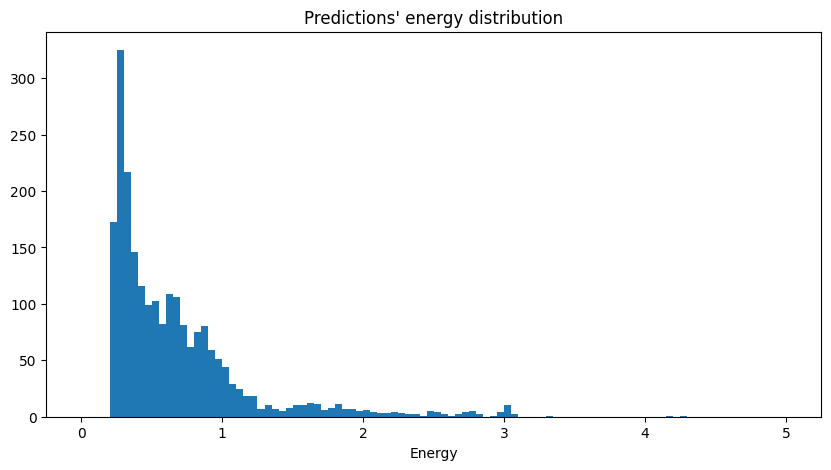

In [17]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

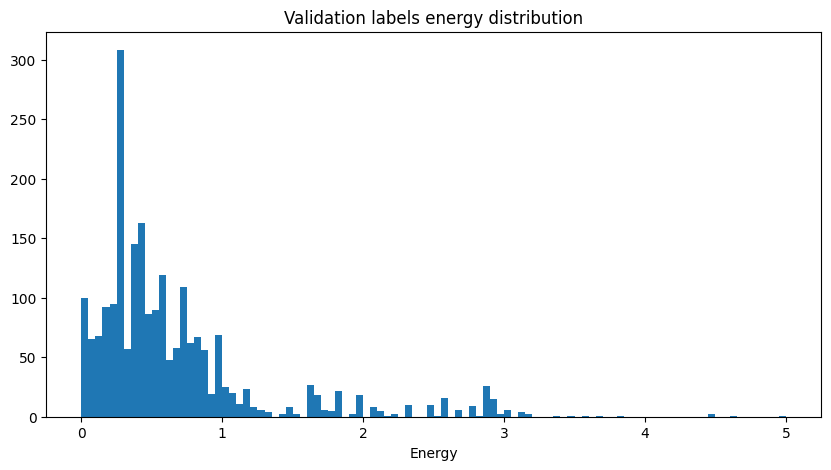

In [18]:
val_labels = true_energies

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()

In [19]:
median = np.median(true_energies)
std = np.std(true_energies)

print(f"Labels' median: {median}, Labels' std: {std}")

Labels' median: 0.4756506511600576, Labels' std: 0.9289945988537212


In [20]:
mse = round(mean_squared_error(true_energies, preds), 3)
mae = round(mean_absolute_error(true_energies, preds), 3)

print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.252
MAE: 0.239


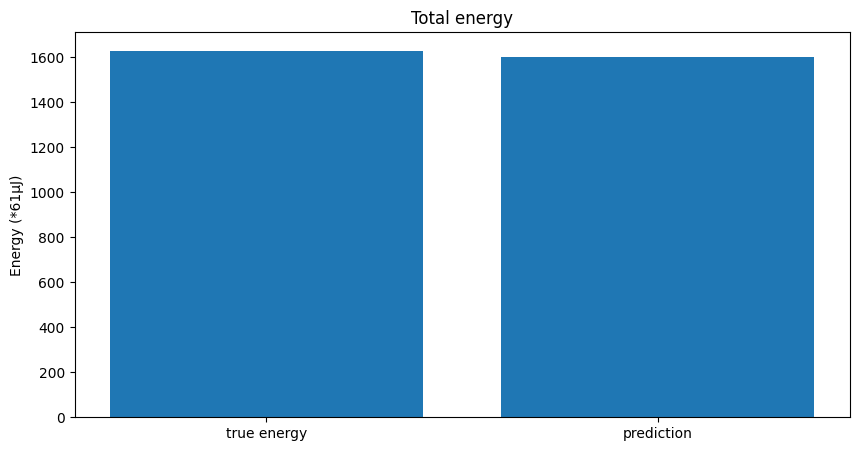

In [21]:
plt.figure(figsize=(10, 5))
plt.title("Total energy")
plt.ylabel("Energy (*61μJ)")
plt.bar(["true energy", "prediction"], [sum(true_energies), sum(preds)])
plt.show()

In [25]:
train=reload(train)

In [26]:
test_df = data_df.sample(n=50)

test_bbs = test_df.bb.tolist()
test_labels = test_df.energy.tolist()

test_preds = train.predict(model=model, test_bbs=test_bbs, vocab=vocab)

print(f"Test preds mae: {mean_absolute_error(test_preds, test_labels)}")

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.